# SWB Regression Pipeline - Beta Power Profit+ CPE


Created: 09/30/2024 \
Updated: 10/01/2024 \
*ran with 1 sec regression dfs from 09/24/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2



In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



10012024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

# Load beta power data 

In [7]:
epoch_len = '1sec'
band = 'beta'

In [8]:
beta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
beta_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()



roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Electrode-wise Regressions + Permutations

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit+cpe'
n_permutations = 1000


In [15]:
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2827.83it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2846.83it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2952.71it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2855.09it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2830.30it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2822.17it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2819.68it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2820.53it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2818.21it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2826.40it/s]


In [16]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit', 'cpe']

In [17]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.062546   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.059776   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.045296   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.006621   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.039904   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.032609   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.063361   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.008160   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                     0.015603   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.104363   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.123692                  -0.030400   
1                                  -0.081996                  -0.068915   
2                                  -0.078744                  -0.030502   
3                                  -0.019422                   0.154621   
4                                  -0.043379                   0.010612   
...                                      ...                        ...   
1183                               -0.006930                  -0.055182   
1184                               -0.001036                  -0.066193   
1185                               -0.126995                  -0.044795   
1186                               -0.051298                   0.030790   
1187                               -0.156352                  -0.059971   

      Original_Estimate_Profit  Original_Estimate_cpe  \
0                     0.096914               0.012293   
1                     0.114857              -0.037969   
2                     0.079792               0.039892   
3                    -0.121206               0.087945   
4                    -0.026468               0.032195   
...                        ...                    ...   
1183                  0.115350              -0.046224   
1184                  0.109395              -0.030302   
1185                  0.019464               0.045161   
1186                 -0.001642               0.049599   
1187                  0.043241               0.116792   

      Permuted_Mean_Intercept  ...  Z_Score_Intercept  \
0                   -0.022685  ...           2.767677   
1                    0.001180  ...           1.990359   
2                   -0.009831  ...           1.965110   
3                   -0.006593  ...           0.448989   
4                    0.010232  ...           1.007980   
...                       ...  ...                ...   
1183                 0.028948  ...           0.212514   
1184                 0.061021  ...           0.104327   
1185                -0.060696  ...           2.769281   
1186                -0.001611  ...           1.004040   
1187                 0.040076  ...           2.599970   

      Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_Profit  \
0                        -2.771690        -0.497155        1.458420   
1                        -1.998423        -1.243261        1.953043   
2                        -1.961873        -0.529709        1.344563   
3                        -0.443863         2.644753       -2.014923   
4                        -1.003318         0.186989       -0.404902   
...                            ...              ...             ...   
1183                     -0.129896        -0.922817        1.642062   
1184                     -0.015620        -0.877316        1.239935   
1185                     -2.899202        -0.731241        0.287860   
1186                     -1.234748         0.521925        0.003285   
1187                  

In [18]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TrialEV', 'Original_Estimate_Profit',
       'Original_Estimate_cpe', 'Permuted_Mean_Intercept',
       'Permuted_Mean_GambleChoice[T.safe]', 'Permuted_Mean_TrialEV',
       'Permuted_Mean_Profit', 'Permuted_Mean_cpe', 'Permuted_Std_Intercept',
       'Permuted_Std_GambleChoice[T.safe]', 'Permuted_Std_TrialEV',
       'Permuted_Std_Profit', 'Permuted_Std_cpe', 'Z_Score_Intercept',
       'Z_Score_GambleChoice[T.safe]', 'Z_Score_TrialEV', 'Z_Score_Profit',
       'Z_Score_cpe', 'P_Value_Intercept', 'P_Value_GambleChoice[T.safe]',
       'P_Value_TrialEV', 'P_Value_Profit', 'P_Value_cpe'],
      dtype='object')

In [19]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_Profit_cpe_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Coefficients

In [20]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
3       MS002_lacas4-lacas5   MS002    acc   14                     0.006621   
12      MS002_laims1-laims2   MS002   ains   14                     0.352121   
16      MS002_laims5-laims6   MS002   ains   14                     0.204013   
20    MS002_laims12-laims13   MS002  dmpfc   14                     0.085196   
26      MS002_lloif1-lloif2   MS002    ofc   14                     0.173665   
56      MS002_ragit2-ragit3   MS002    amy   14                     0.048083   
60      MS002_raims3-raims4   MS002   ains   14                     0.265396   
93      MS003_lmolf2-lmolf3   MS003    ofc    8                    -0.063956   
98      MS003_lsifo1-lsifo2   MS003   pins    8                    -0.024700   
167     MS009_lpipm3-lpipm4   MS009   pins   16                     0.005256   
217     MS015_lmolf7-lmolf8   MS015  vlpfc   26                    -0.036804   
220     MS015_raglt2-raglt3   MS015    amy   26                    -0.024010   
267     MS016_rhpit2-rhpit3   MS016    hpc   10                    -0.012125   
280     MS017_lalps1-lalps2   MS017   ains   26                     0.300819   
313     MS019_lmoif4-lmoif5   MS019    ofc   12                    -0.057355   
316     MS019_lmoif7-lmoif8   MS019  vlpfc   12                    -0.076890   
347     MS024_lacas4-lacas5   MS024    acc   16                    -0.043213   
432     MS025_racas4-racas5   MS025    acc   10                     0.309752   
434     MS025_racas7-racas8   MS025  dlpfc   10                    -0.037715   
441     MS025_rmcms6-rmcms7   MS025  dmpfc   10                     0.092355   
444     MS025_rmolf2-rmolf3   MS025    ofc   10                     0.040554   
467     MS026_racas7-racas8   MS026  dmpfc    9                     0.006453   
509     MS027_liisp3-liisp4   MS027   pins   22                    -0.061677   
520     MS027_racas5-racas6   MS027    acc   22                    -0.062726   
524     MS027_rmcms3-rmcms4   MS027  dmpfc   22                    -0.071541   
550     MS028_laglt1-laglt2   MS028    amy   13                    -0.017874   
553     MS028_lhplt1-lhplt2   MS028    hpc   13                    -0.015363   
554     MS028_lhplt2-lhplt3   MS028    hpc   13                     0.007004   
588     MS028_rhplt1-rhplt2   MS028    hpc   13                    -0.024143   
623     MS028_rmolf5-rmolf6   MS028    ofc   13                     0.286833   
655     MS029_lmolf4-lmolf5   MS029    ofc   32                    -0.032102   
758     MS035_lacas8-lacas9   MS035  dlpfc   15                    -0.019977   
759    MS035_lacas9-lacas10   MS035  dlpfc   15                    -0.038243   
764     MS035_laimm1-laimm2   MS035   pins   15                     0.053033   
796     MS035_racas7-racas8   MS035    acc   15                     0.008239   
808     MS035_raims8-raims9   MS035  dlpfc   15                    -0.123198   
810   MS035_raims10-raims11   MS035  dmpfc   15                    -0.151626   
849     MS041_lais13-lais14   MS041  dlpfc   10                    -0.011084   
851       MS041_lcm13-lcm14   MS041  dlpfc   10                    -0.114213   
893       MS041_rcm12-rcm13   MS041  dlpfc   10                    -0.047674   
923     MS043_lmcms2-lmcms3   MS043    acc   23                     0.160840   
933     MS043_lmolf8-lmolf9   MS043    ofc   23                    -0.058030   
945     MS043_rhplt2-rhplt3   MS043    hpc   23                    -0.087287   
986     MS048_lmolf4-lmolf5   MS048    ofc   19                     0.014524   
1037    MS048_rmolf5-rmolf6   MS048    ofc   19                     0.017971   
1049    MS050_lagit1-lagit2   MS050    amy    9                    -0.063363   
1050    MS050_lagit2-lagit3   MS050    amy    9                    -0.033151   
1056  MS050_lainss4-lainss5   MS050   ains    9                     0.231581   
1057  MS050_lainss5-lainss6   MS050   ains    9                     0.147767   
1063    MS050

In [21]:
sig_data.roi.value_counts()



roi
ofc      11
acc       8
dlpfc     8
dmpfc     7
ains      7
pins      6
amy       5
hpc       5
vlpfc     3
Name: count, dtype: int64

In [22]:
sig_data.roi.unique()



array(['acc', 'ains', 'dmpfc', 'ofc', 'amy', 'pins', 'vlpfc', 'hpc',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [23]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.062546   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.059776   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.045296   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.006621   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.039904   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.123692                  -0.030400   
1                               -0.081996                  -0.068915   
2                               -0.078744                  -0.030502   
3                               -0.019422                   0.154621   
4                               -0.043379                   0.010612   

   Original_Estimate_Profit  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.096914               0.012293                -0.022685   
1                  0.114857              -0.037969                 0.001180   
2                  0.079792               0.039892                -0.009831   
3                 -0.121206               0.087945                -0.006593   
4                 -0.026468               0.032195                 0.010232   

   ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_cpe  P_Value_Intercept  \
0  ...        -0.497155        1.458420     0.262277           0.005646   
1  ...        -1.243261        1.953043    -0.799369           0.046551   
2  ...        -0.529709        1.344563     0.943056           0.049401   
3  ...         2.644753       -2.014923     1.980361           0.653439   
4  ...         0.186989       -0.404902     0.678717           0.313464   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_cpe  \
0                      0.005577         0.619080        0.144725     0.793108   
1                      0.045671         0.213772        0.050814     0.424076   
2                      0.049777         0.596314        0.178766     0.345652   
3                      0.657142         0.008175        0.043913     0.047663   
4                      0.315708         0.851670        0.685550     0.497317   

   cpe_sig  bdi_split  
0        0          0  
1        0          0  
2        0          0  
3        1          0  
4        0          0  

[5 rows x 31 columns]

In [24]:
cpe_var = 'Z_Score_cpe'

In [25]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [26]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.103387
vlpfc    0.201397
dmpfc    0.115853
ofc     -0.027011
ains     0.506630
pins     0.329586
acc      0.011067
amy     -0.111815
hpc      0.181673
Name: Z_Score_cpe, dtype: float64

In [27]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [28]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193      8  0.041451              2    0.160293    0.872819   
1  dmpfc      225      7  0.031111              1    1.917125    0.056494   
2    amy      113      5  0.044248              1   -1.206180    0.230290   
3   ains       71      7  0.098592              1    3.763889    0.000345   
4  vlpfc       82      3  0.036585              2    1.706678    0.091713   
5    hpc      135      5  0.037037              1    2.247980    0.026211   
6    ofc      202     11  0.054455              4   -0.362716    0.717199   
7   pins       60      6  0.100000              1    2.148671    0.035775   
8  dlpfc      107      8  0.074766              1    0.982901    0.327894   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.020790            1.0    0.041451      0.7534  
1      0.014691            1.0    0.031111      0.9359  
2      0.017594            1.0    0.044248      0.6717  
3      0.047193            1.0    0.098592      0.0642  
4      0.010045            1.0    0.036585      0.7836  
5      0.014705            1.0    0.037037      0.8101  
6      0.030835            1.0    0.054455      0.4298  
7      0.044453            1.0    0.100000      0.0787  
8      0.037745            1.0    0.074766      0.1673

In [29]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

Empty DataFrame
Columns: [roi, n_total, n_sig, prop_sig, n_sig_highbdi, ttest_stat, ttest_pval, binom_ci_low, binom_ci_high, binom_prop, binom_pval]
Index: []

# Plot Results

In [30]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_Profit_cpe_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim cpe$'

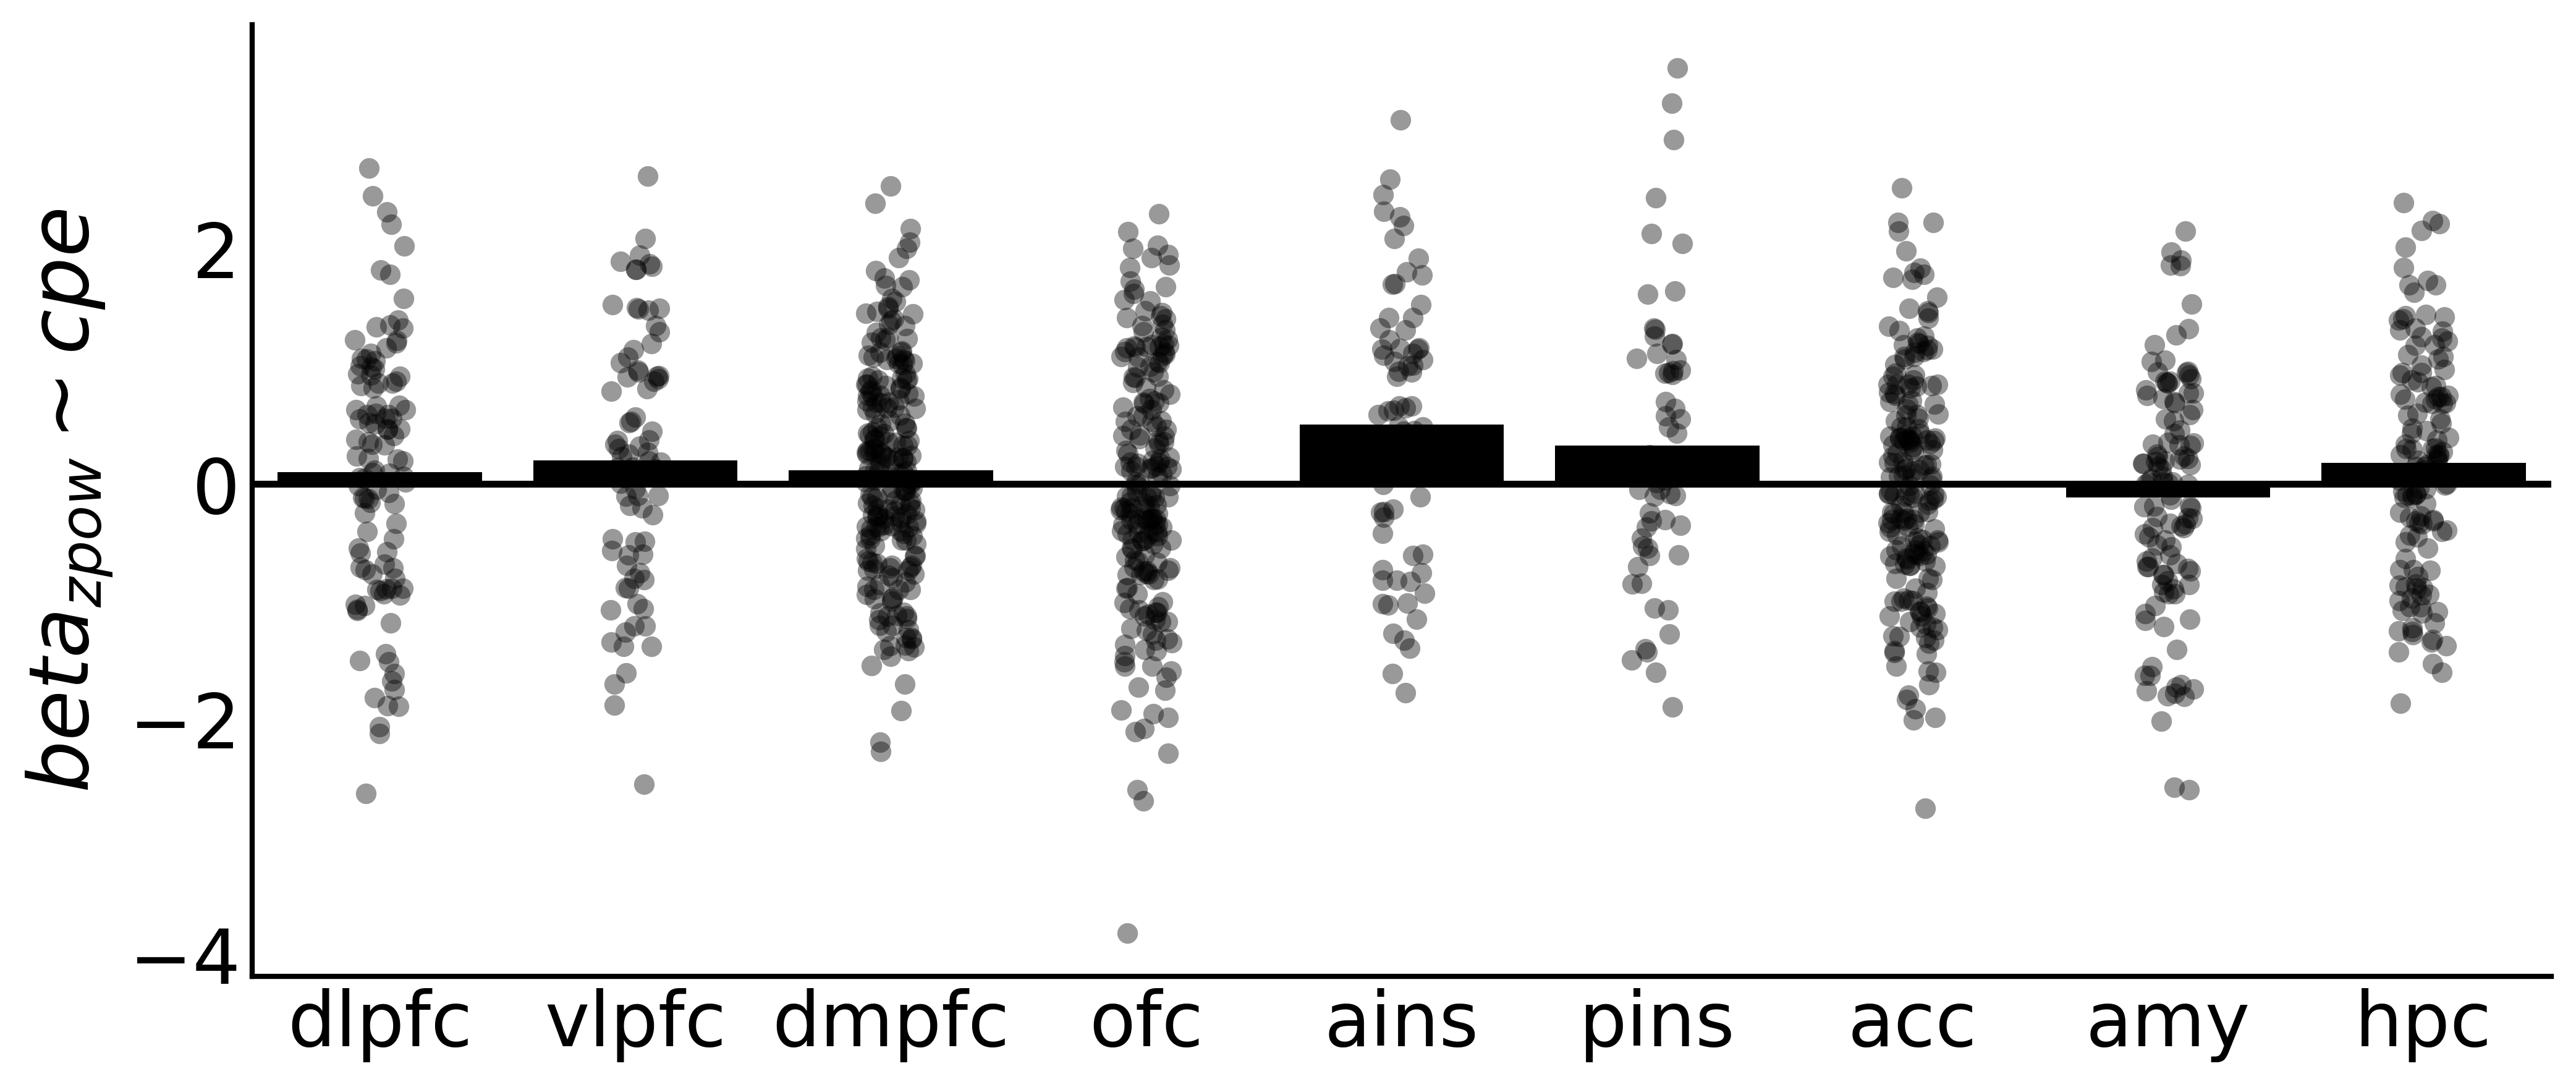

In [31]:
### WITH RPE IN MODEL

plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

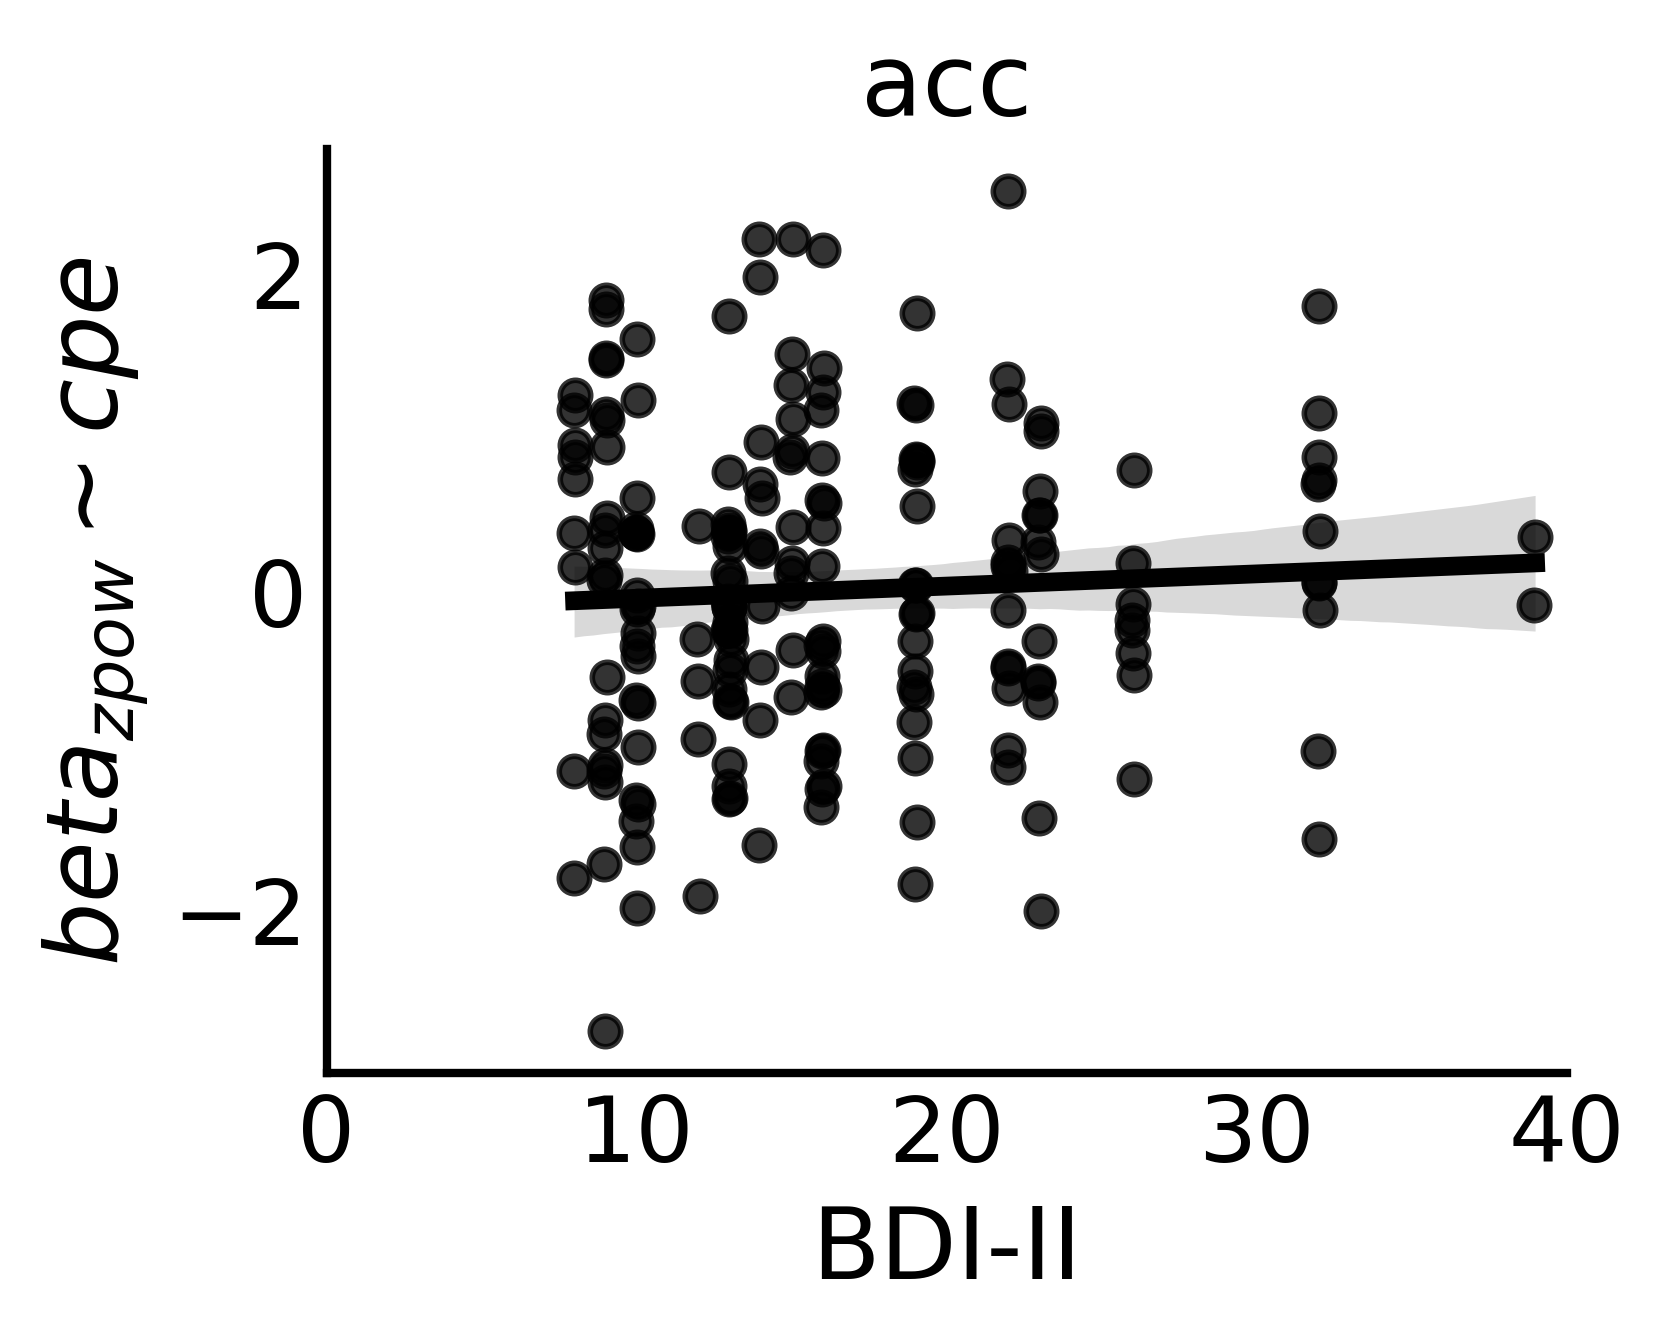

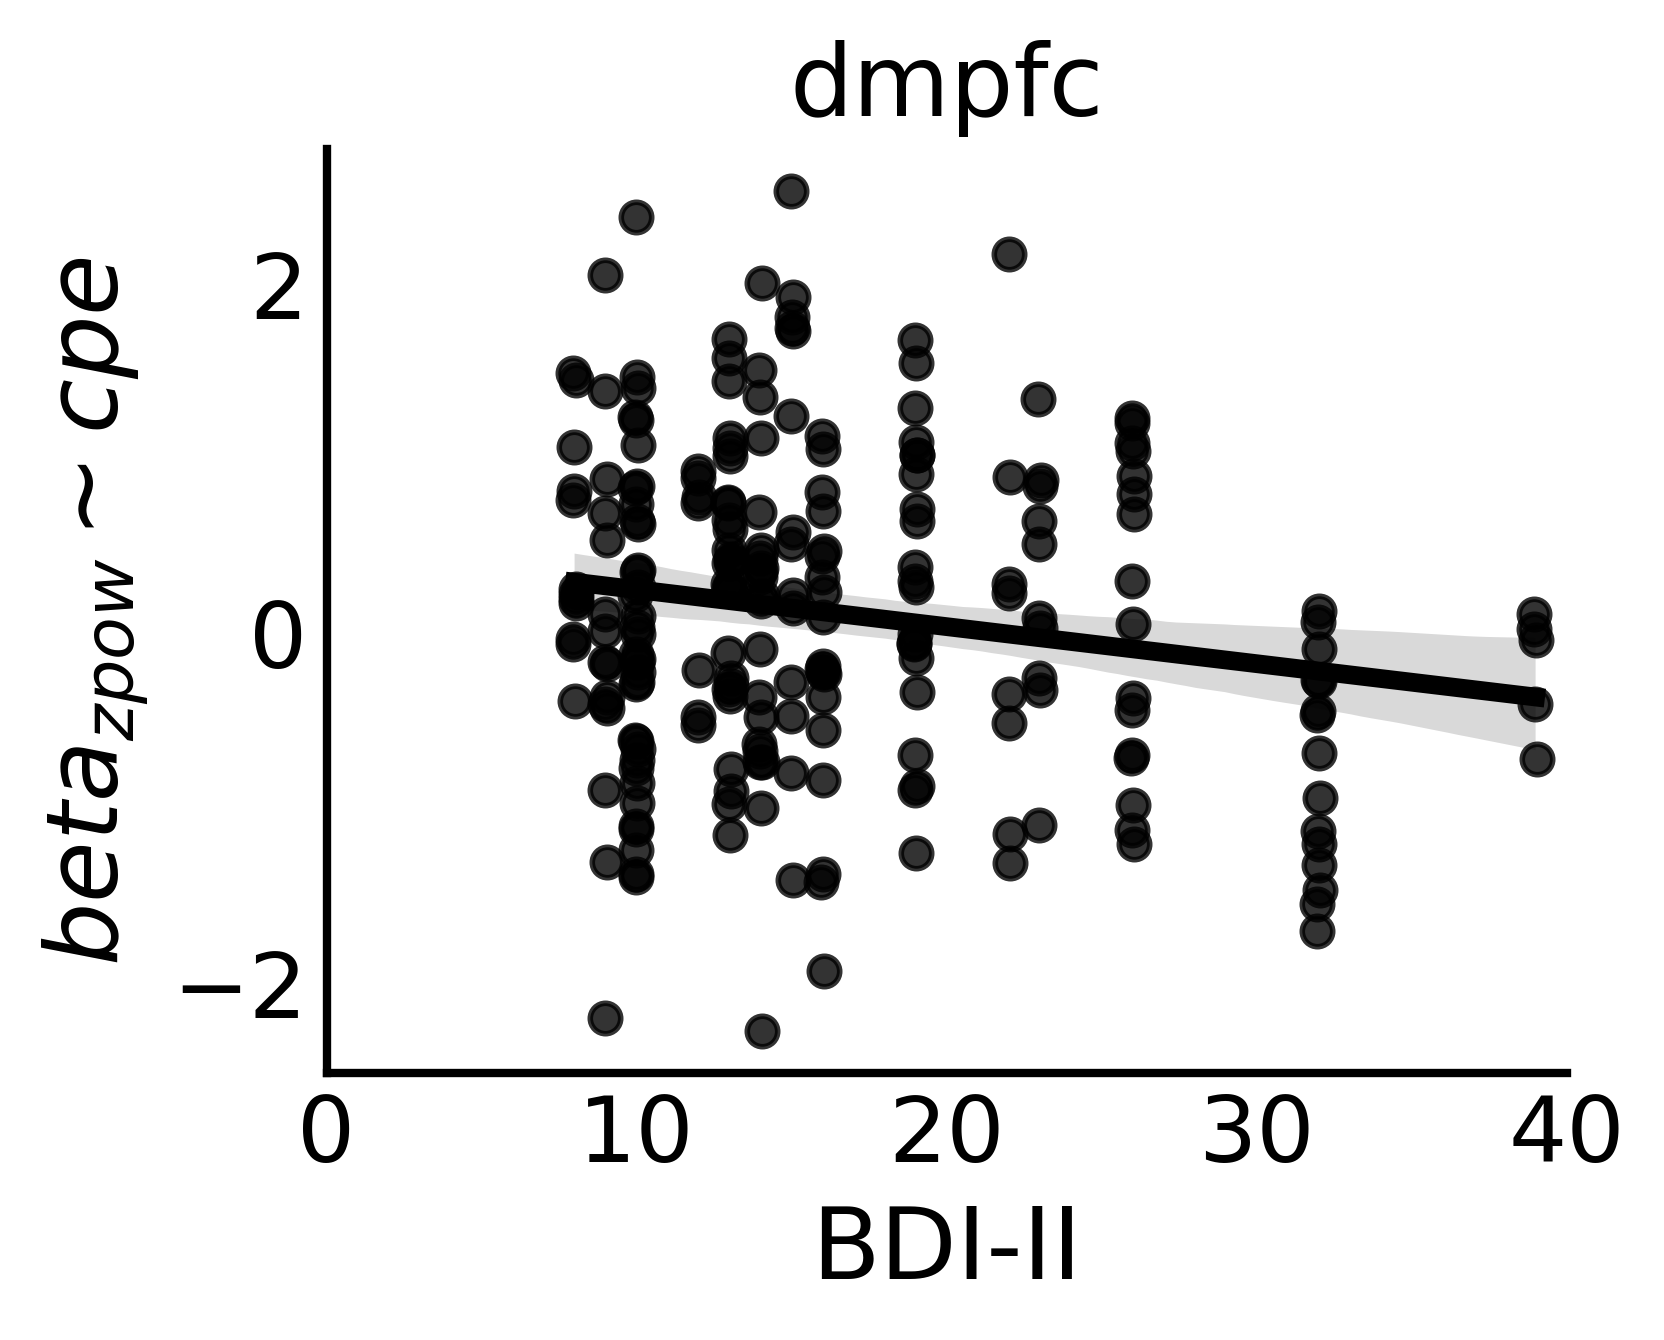

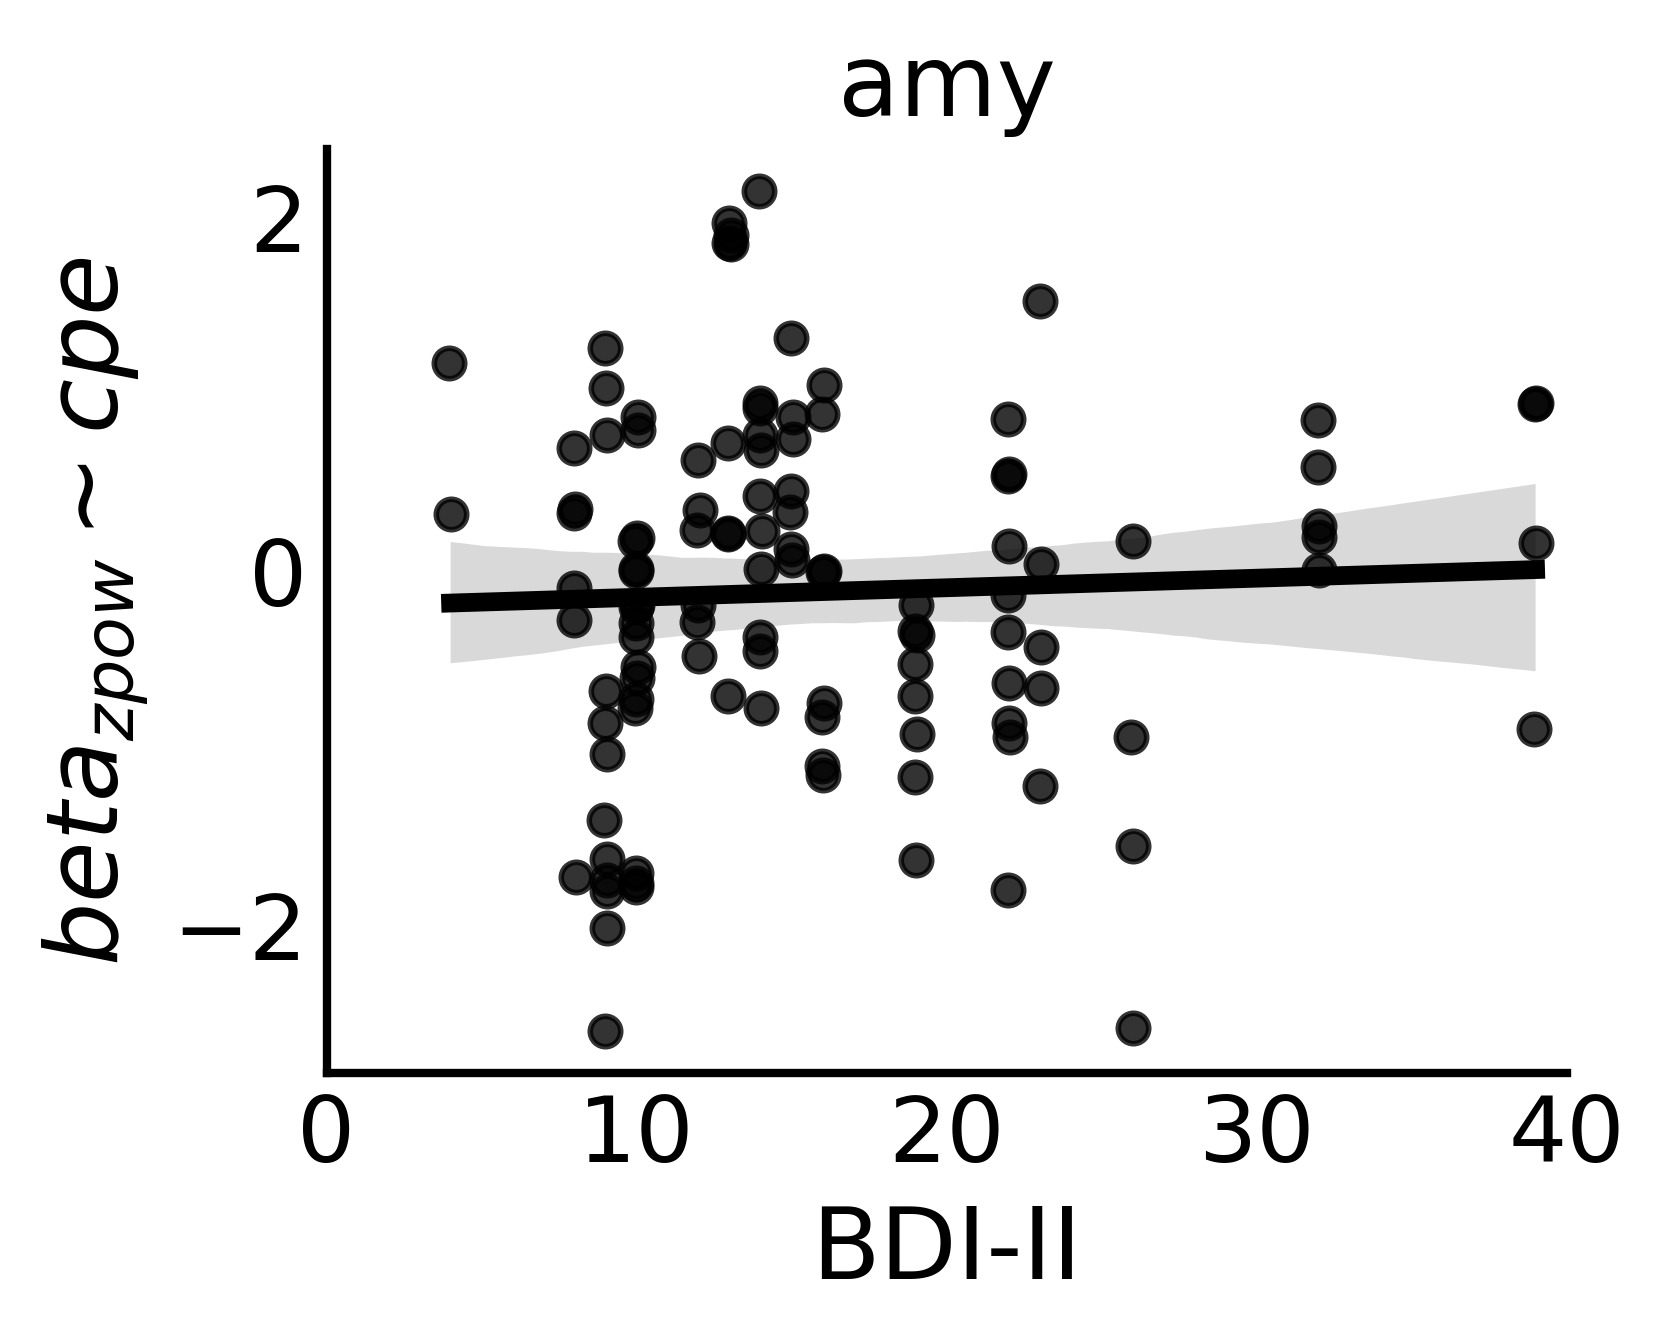

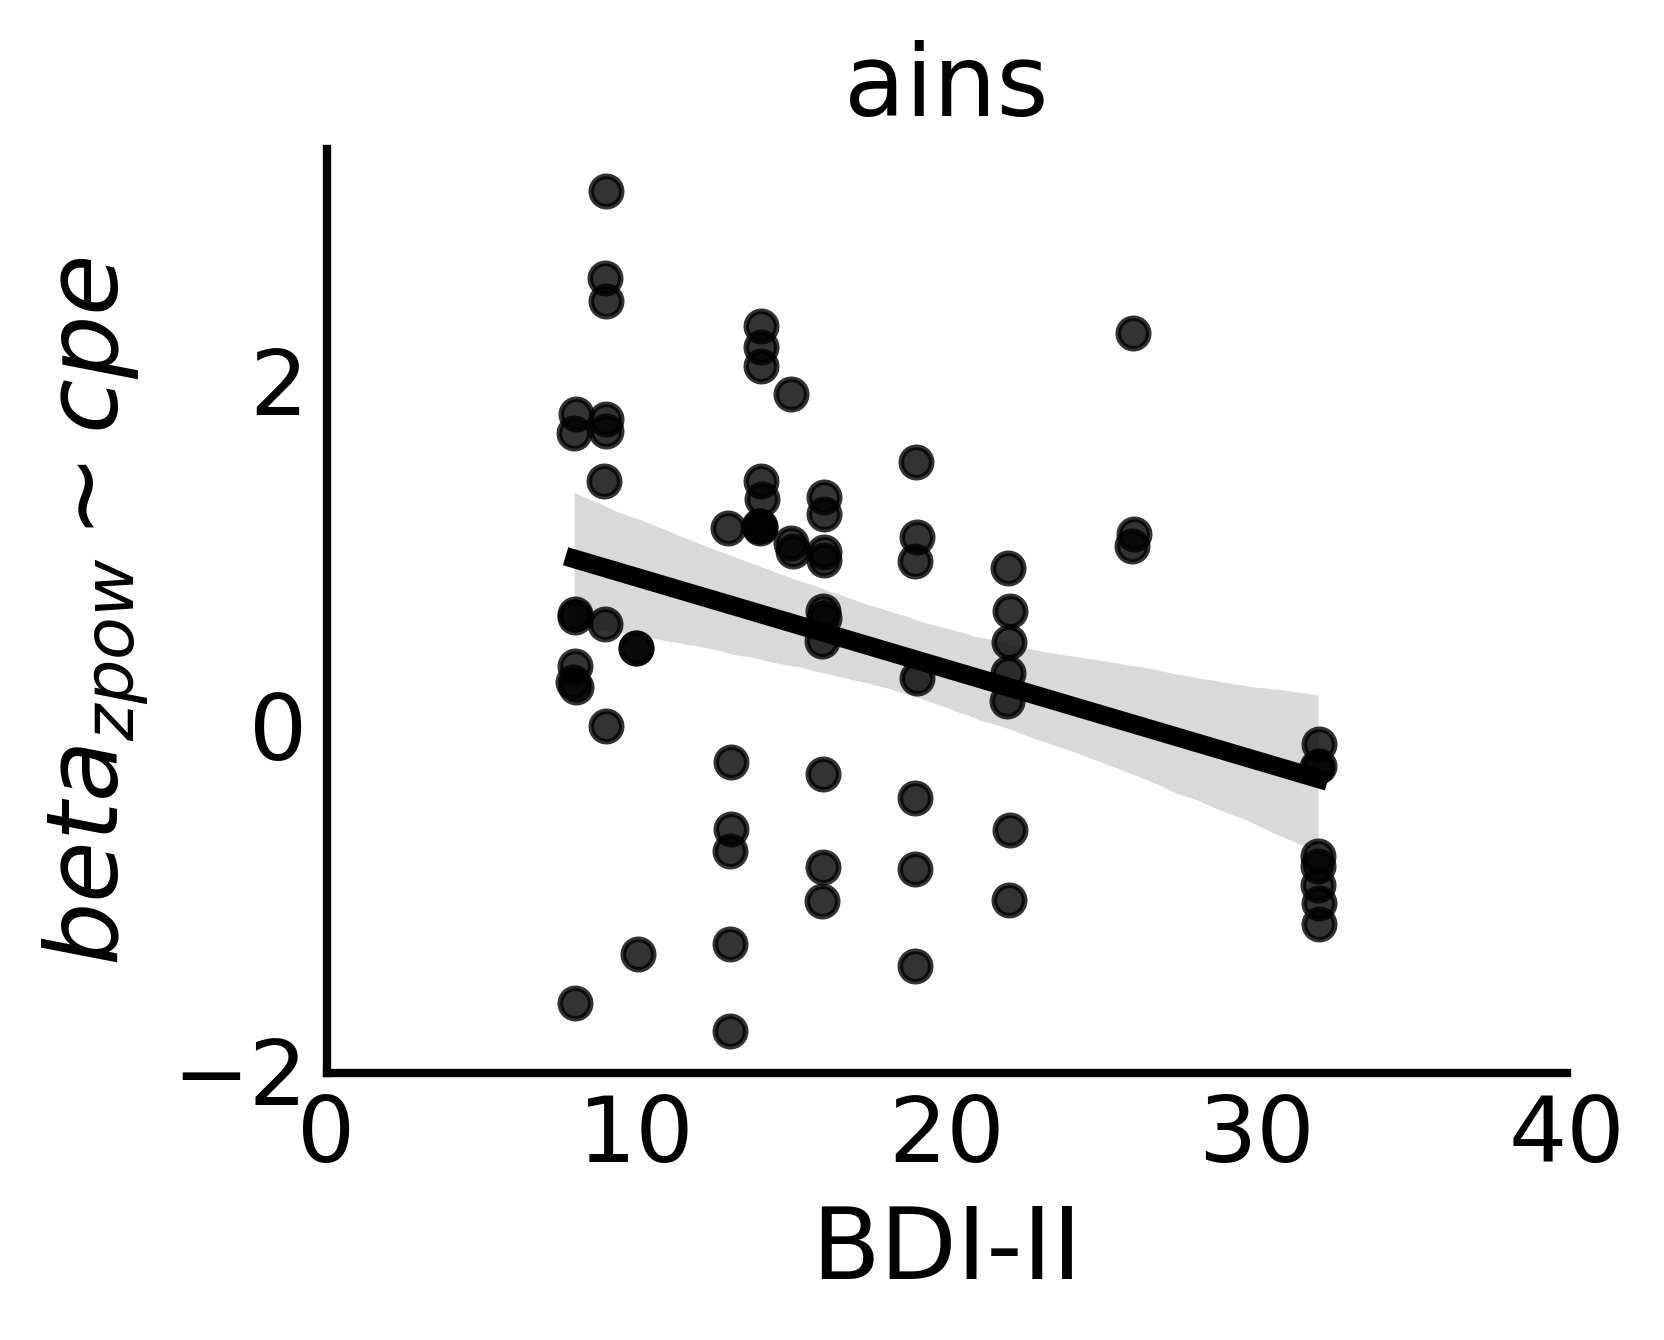

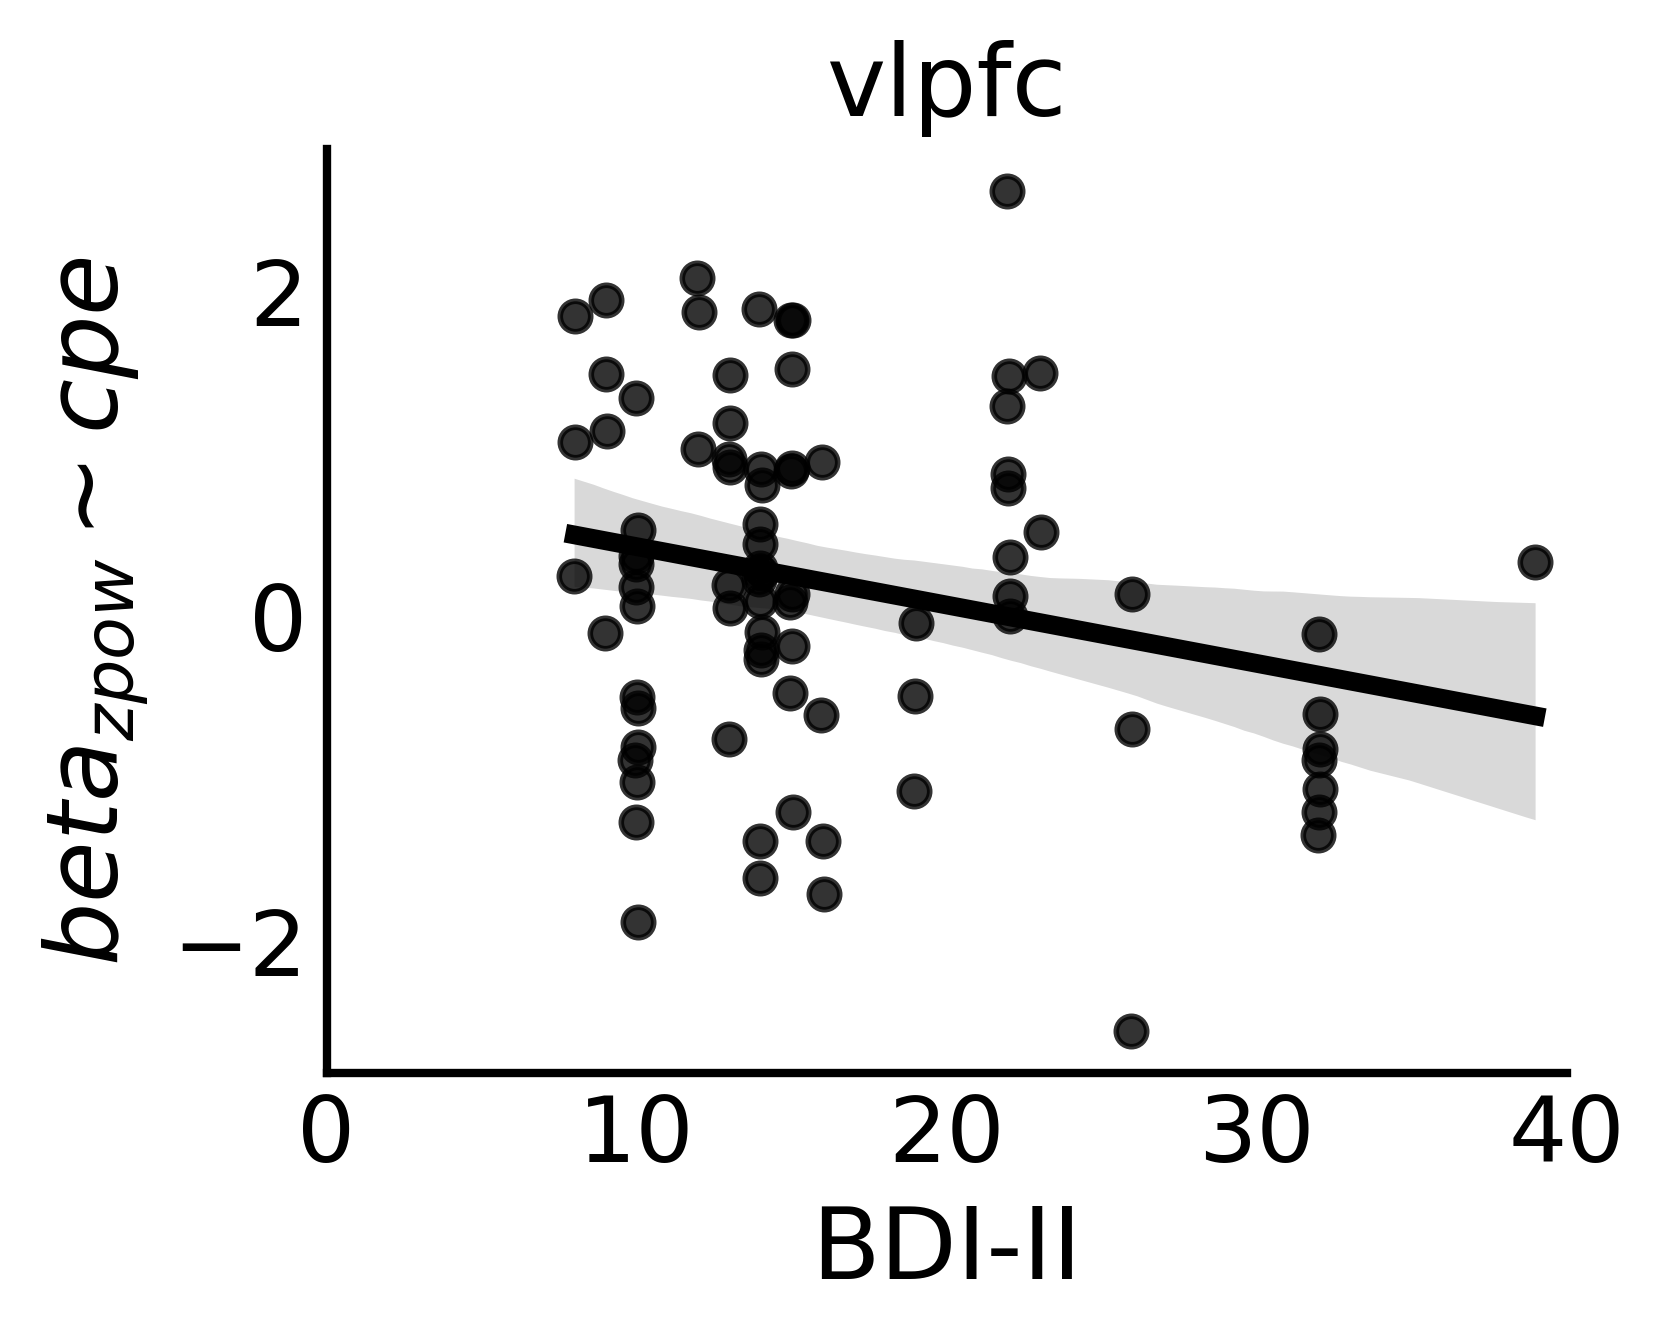

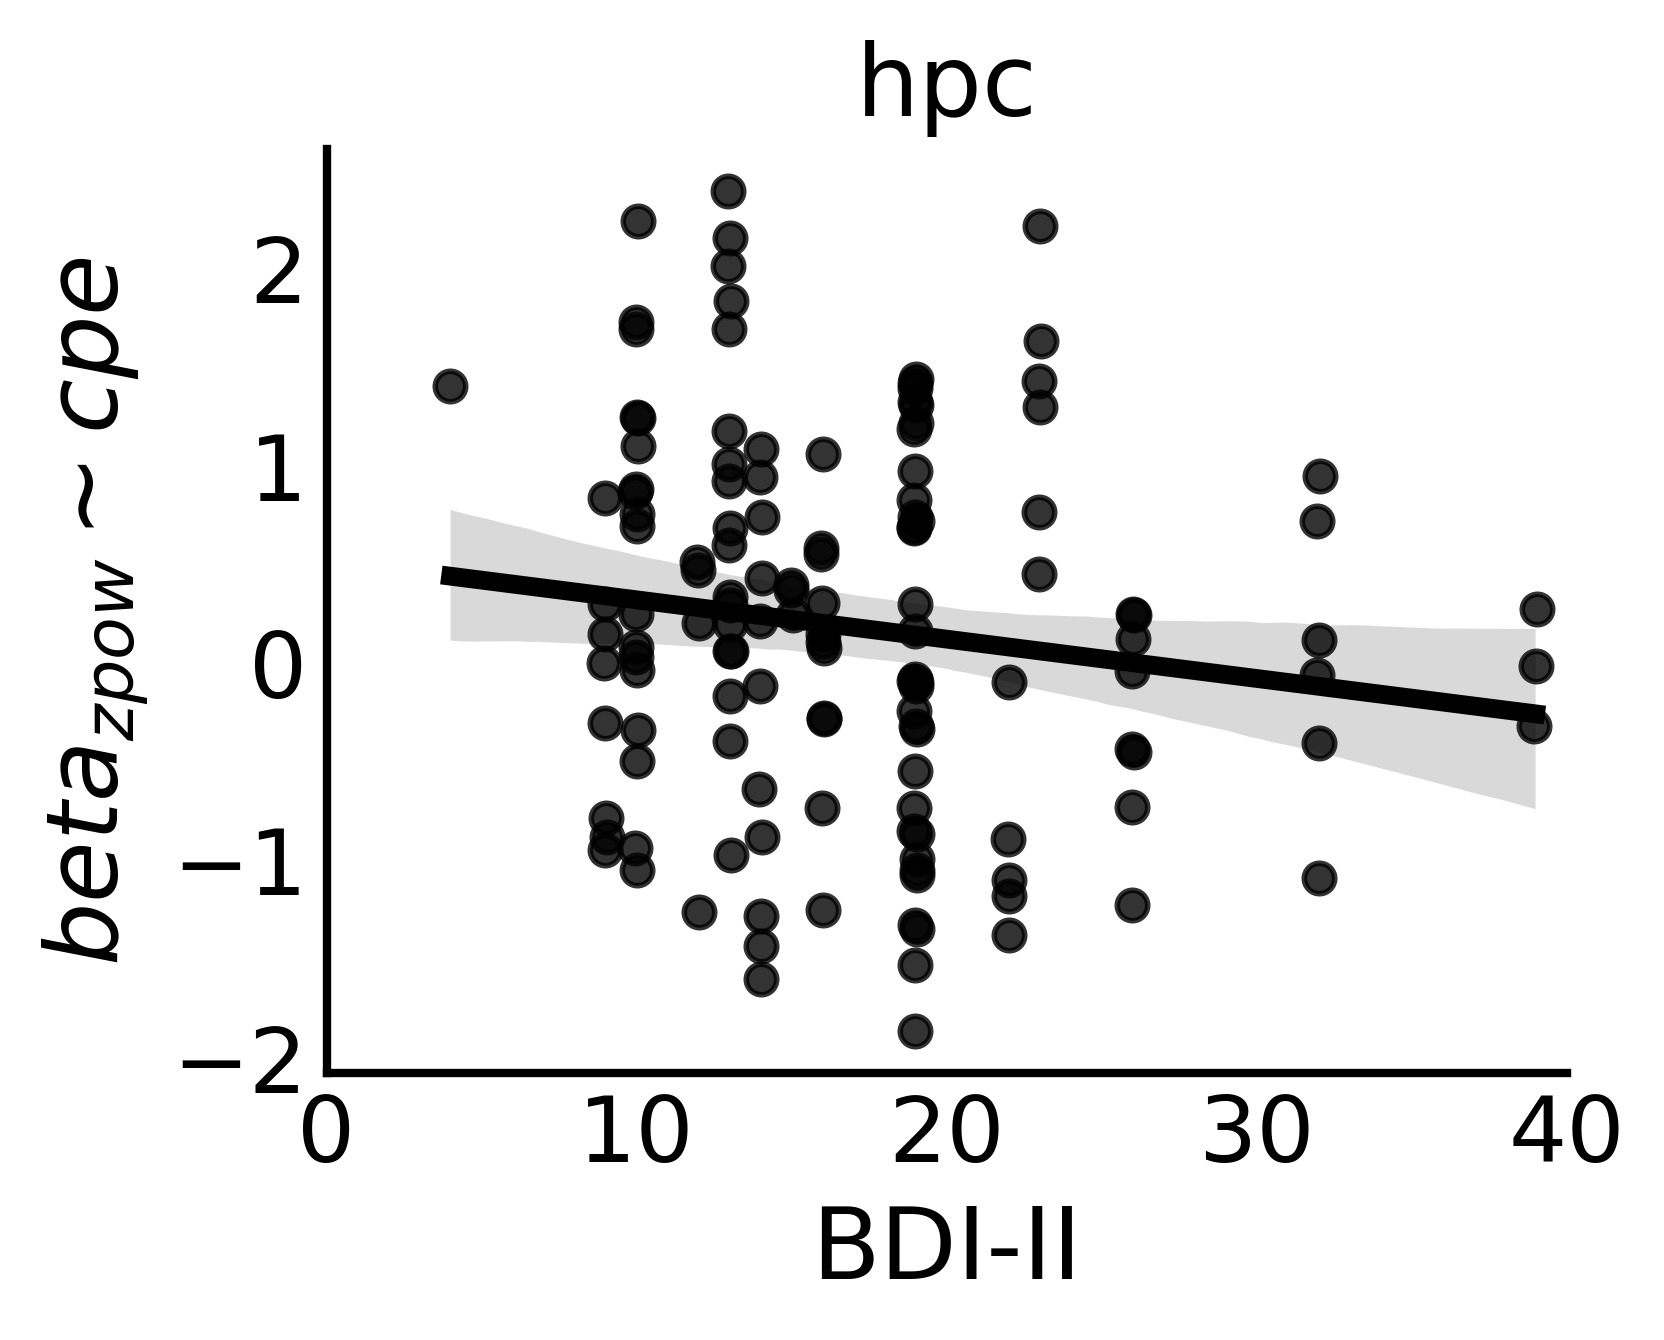

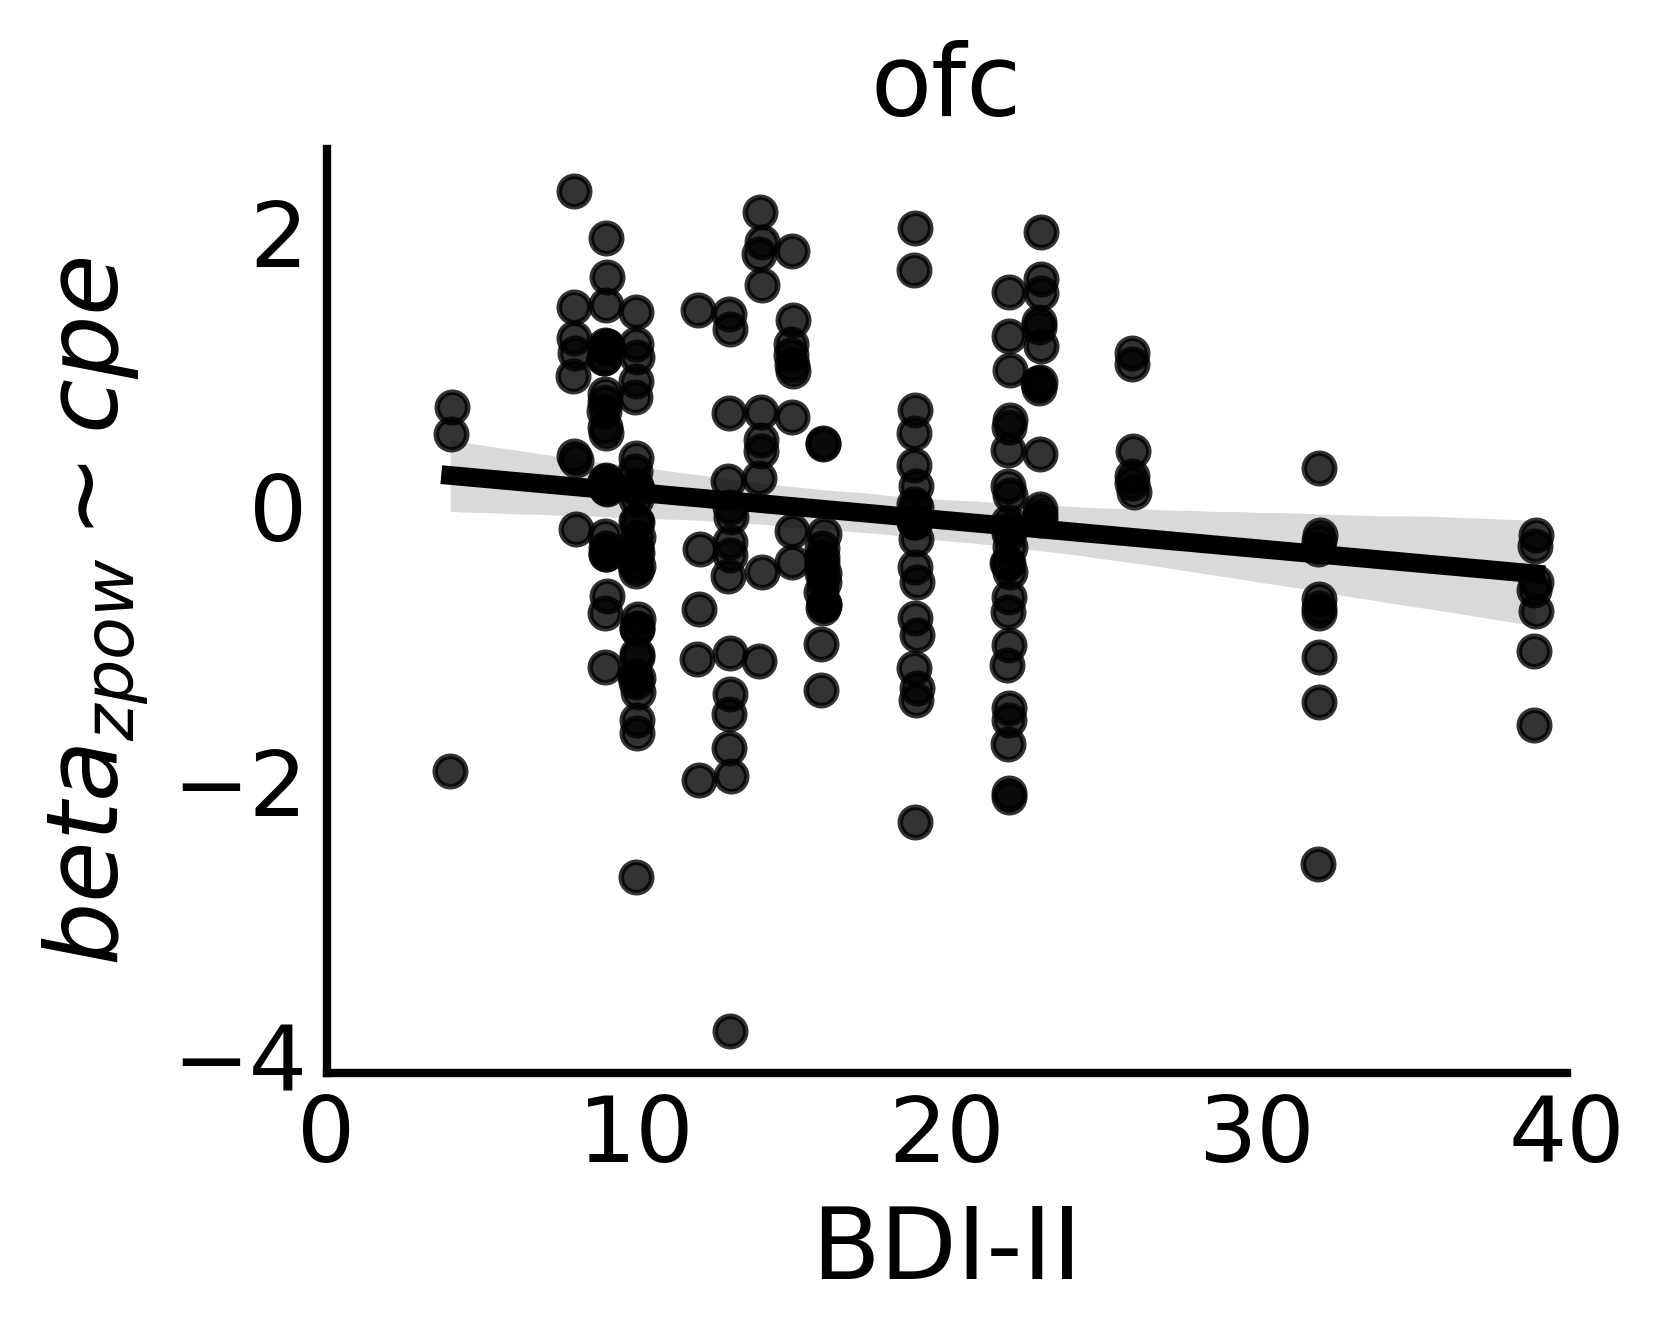

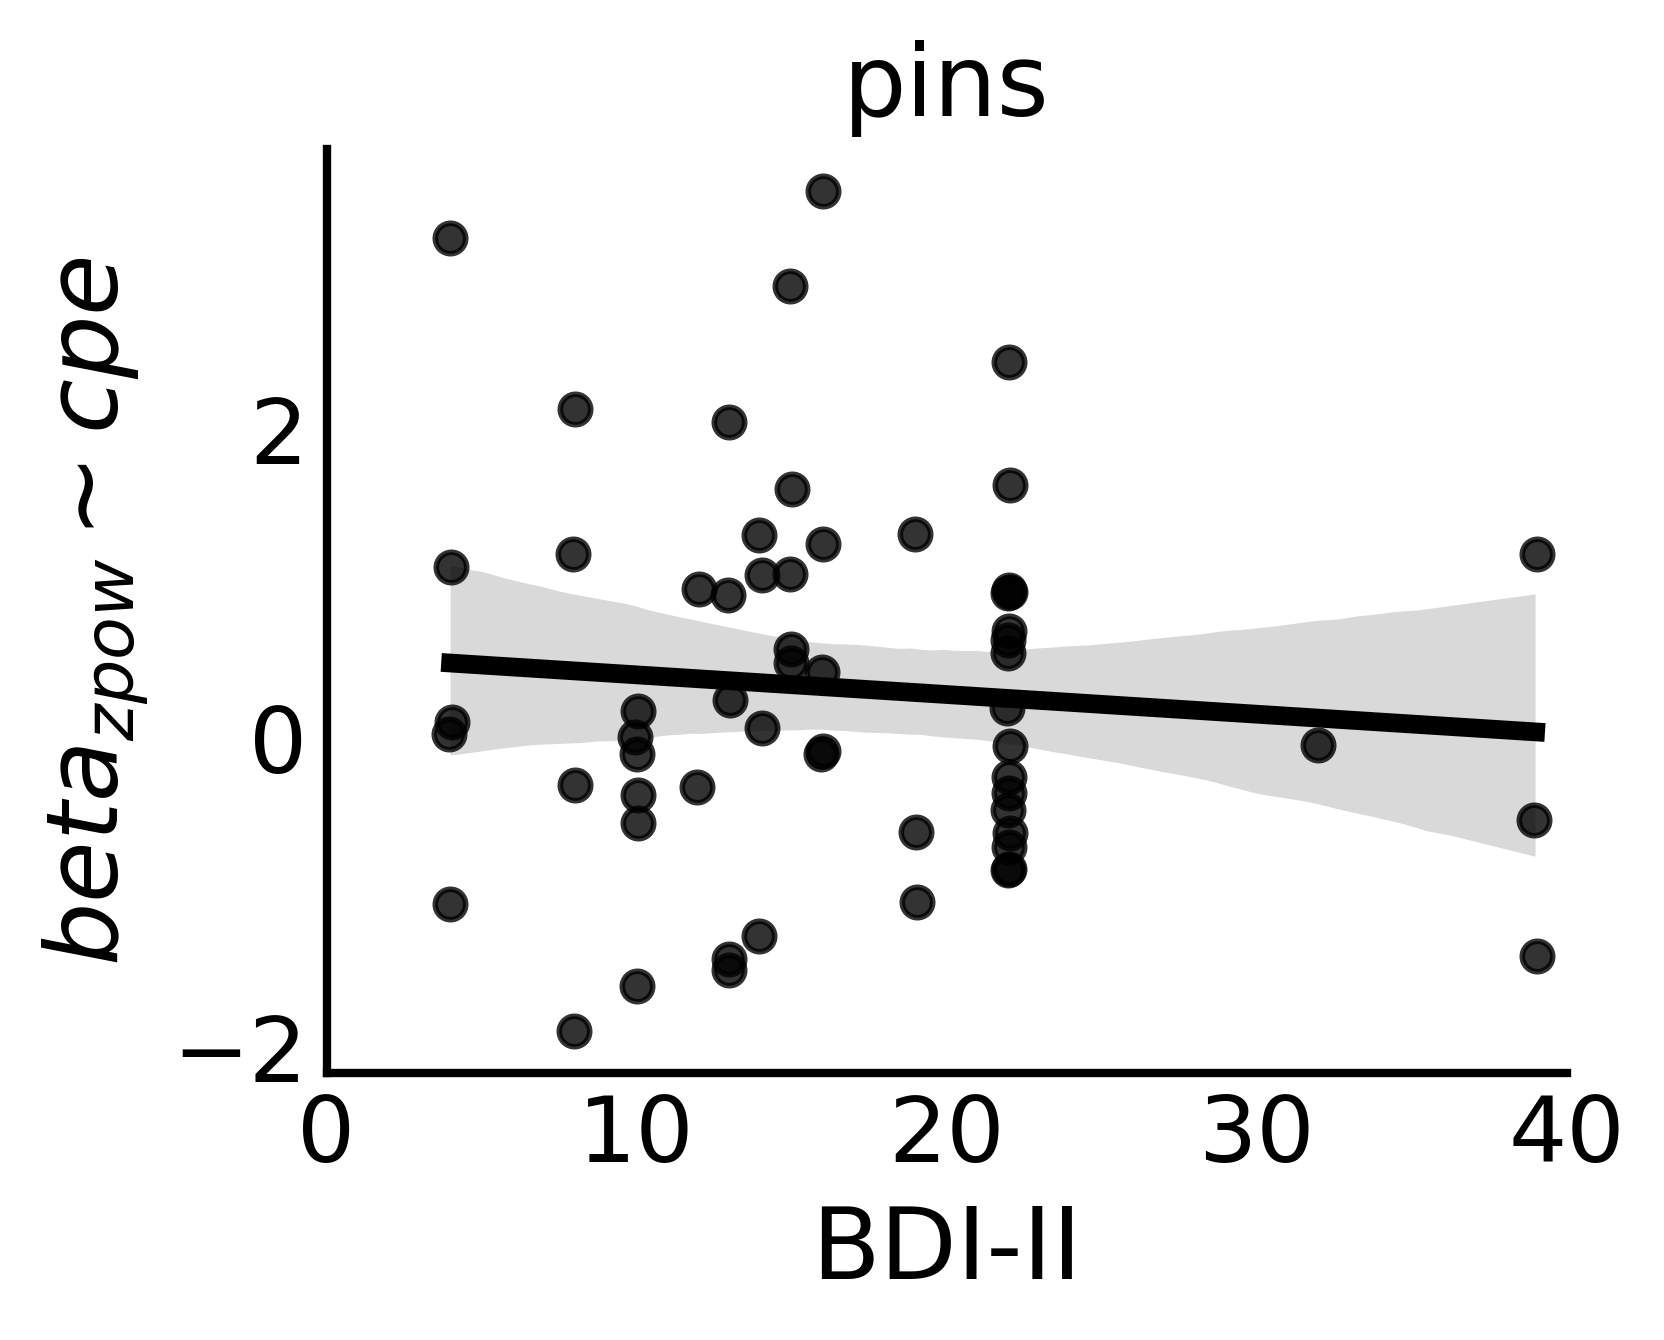

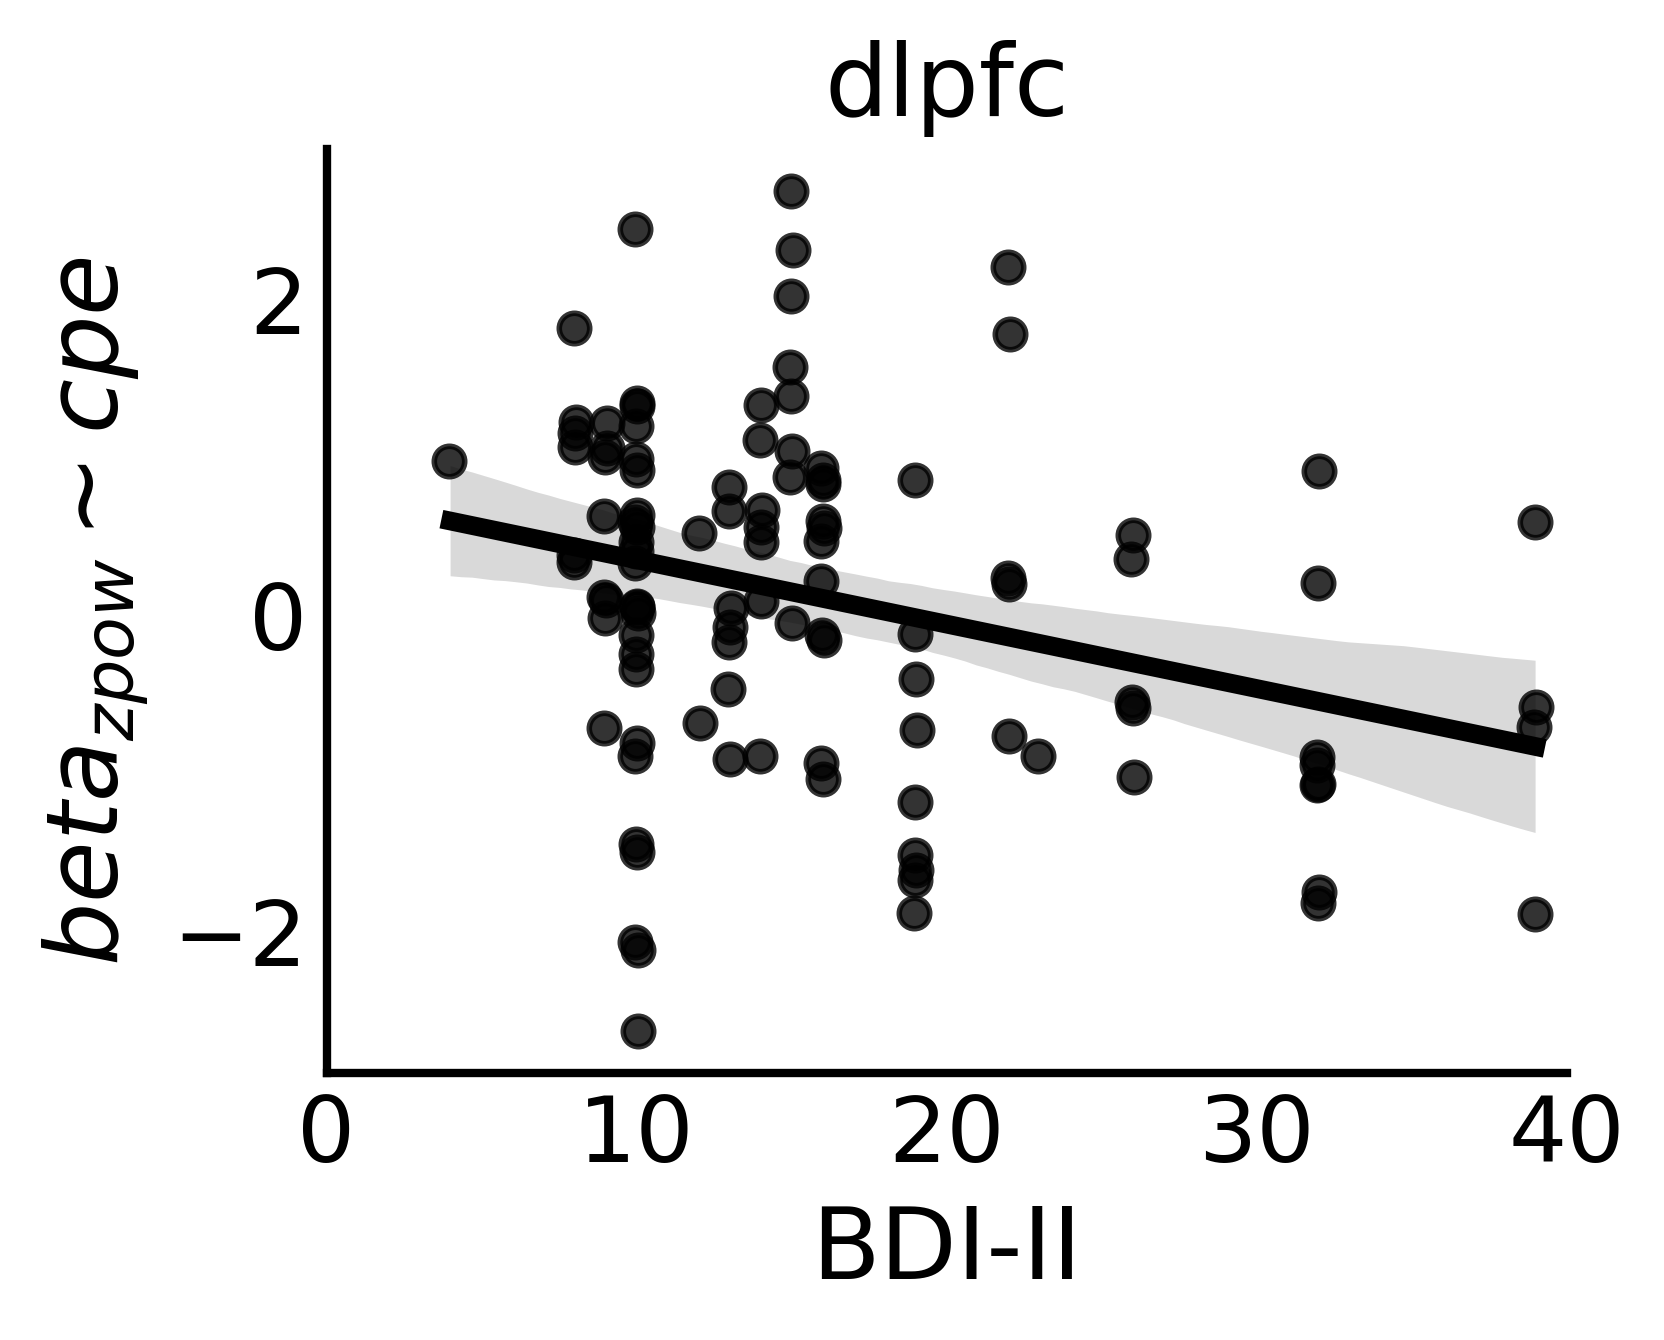

In [32]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_Profit_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [33]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        11:24:33                                         
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8725      0.440     36.084     

In [34]:
# del cpe_var

# Profit Coefficients

In [35]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
3     MS002_lacas4-lacas5   MS002    acc   14                     0.006621   
30    MS002_lloif7-lloif8   MS002  vlpfc   14                     0.172982   
33    MS002_lmoif8-lmoif9   MS002  vlpfc   14                     0.147011   
39    MS002_lpips2-lpips3   MS002   pins   14                     0.005295   
48    MS002_racas1-racas2   MS002    acc   14                    -0.015526   
...                   ...     ...    ...  ...                          ...   
1117      DA023_lac2-lac3   DA023    acc   14                     0.015387   
1147      DA037_rof3-rof4   DA037    ofc    4                    -0.163025   
1156      DA039_ram4-ram5   DA039    amy   22                    -0.025300   
1178      DA039_rof7-rof8   DA039  vlpfc   22                    -0.019643   
1181    DA039_rof10-rof11   DA039  dlpfc   22                     0.056561   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
3                                  -0.019422                   0.154621   
30                                 -0.211053                  -0.200362   
33                                 -0.240003                  -0.216134   
39                                 -0.042633                   0.055487   
48                                 -0.006716                  -0.112433   
...                                      ...                        ...   
1117                               -0.031999                  -0.133647   
1147                                0.048138                  -0.067335   
1156                               -0.035687                  -0.128380   
1178                               -0.040640                   0.144711   
1181                               -0.108682                  -0.078055   

      Original_Estimate_Profit  Original_Estimate_cpe  \
3                    -0.121206               0.087945   
30                    0.180650              -0.018392   
33                    0.217257              -0.085807   
39                   -0.134392               0.048471   
48                    0.143245              -0.016861   
...                        ...                    ...   
1117                  0.142688              -0.086366   
1147                  0.162123              -0.083081   
1156                  0.129433              -0.088569   
1178                 -0.173807               0.140601   
1181                  0.167149              -0.039513   

      Permuted_Mean_Intercept  ...  Z_Score_TrialEV  Z_Score_Profit  \
3                   -0.006593  ...         2.644753       -2.014923   
30                   0.025690  ...        -2.761401        2.279547   
33                  -0.019106  ...        -2.790135        2.574861   
39                  -0.025763  ...         0.908030       -2.165917   
48                  -0.018714  ...        -2.240302        2.747595   
...                       ...  ...              ...             ...   
1117                 0.000188  ...        -2.015356        2.050064   
1147                -0.153184  ...        -1.794591        2.917589   
1156                -0.045597  ...        -2.391820        2.087328   
1178                -0.029544  ...         2.540489       -2.574928   
1181                 0.011464  ...        -1.338759        2.394127   

      Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
3        1.980361           0.653439                      0.657142   
30      -0.260079           0.000047                      0.000047   
33      -1.377397           0.000008                      0.000008   
39       1.058205           0.284402                      0.289297   
48      -0.468721           0.900980                      0.899537   
...           ...                ...                           ...   
1117    -1.589462           0.470616                      0.481968   
1147    -1.920919           0.143662                      0.097706   
1156 

In [36]:
sig_data.roi.value_counts()



roi
ofc      13
acc      12
dmpfc     9
amy       8
hpc       7
vlpfc     6
pins      4
ains      4
dlpfc     3
Name: count, dtype: int64

In [37]:
sig_data.roi.unique()



array(['acc', 'vlpfc', 'pins', 'dmpfc', 'amy', 'ofc', 'hpc', 'ains',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [38]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.062546   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.059776   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.045296   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.006621   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.039904   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.123692                  -0.030400   
1                               -0.081996                  -0.068915   
2                               -0.078744                  -0.030502   
3                               -0.019422                   0.154621   
4                               -0.043379                   0.010612   

   Original_Estimate_Profit  Original_Estimate_cpe  Permuted_Mean_Intercept  \
0                  0.096914               0.012293                -0.022685   
1                  0.114857              -0.037969                 0.001180   
2                  0.079792               0.039892                -0.009831   
3                 -0.121206               0.087945                -0.006593   
4                 -0.026468               0.032195                 0.010232   

   ...  Z_Score_Profit  Z_Score_cpe  P_Value_Intercept  \
0  ...        1.458420     0.262277           0.005646   
1  ...        1.953043    -0.799369           0.046551   
2  ...        1.344563     0.943056           0.049401   
3  ...       -2.014923     1.980361           0.653439   
4  ...       -0.404902     0.678717           0.313464   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_cpe  \
0                      0.005577         0.619080        0.144725     0.793108   
1                      0.045671         0.213772        0.050814     0.424076   
2                      0.049777         0.596314        0.178766     0.345652   
3                      0.657142         0.008175        0.043913     0.047663   
4                      0.315708         0.851670        0.685550     0.497317   

   cpe_sig  bdi_split  Profit_sig  
0        0          0           0  
1        0          0           0  
2        0          0           0  
3        1          0           1  
4        0          0           0  

[5 rows x 32 columns]

In [39]:
Profit_var = 'Z_Score_Profit'

In [40]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [41]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc    0.144287
vlpfc    0.159664
dmpfc   -0.030255
ofc      0.083438
ains     0.269907
pins     0.060209
acc      0.258558
amy      0.159547
hpc     -0.073804
Name: Z_Score_Profit, dtype: float64

In [42]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [43]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     12  0.062176              1    3.512775    0.000553   
1  dmpfc      225      9  0.040000              2   -0.484373    0.628595   
2    amy      113      8  0.070796              2    1.668844    0.097941   
3   ains       71      4  0.056338              1    2.148423    0.035142   
4  vlpfc       82      6  0.073171              2    1.297148    0.198263   
5    hpc      135      7  0.051852              0   -0.907788    0.365620   
6    ofc      202     13  0.064356              4    1.101673    0.271921   
7   pins       60      4  0.066667              0    0.423602    0.673396   
8  dlpfc      107      3  0.028037              1    1.574426    0.118369   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.036265            1.0    0.062176      0.2603  
1      0.021023            1.0    0.040000      0.7963  
2      0.035713            1.0    0.070796      0.2049  
3      0.019470            1.0    0.056338      0.4771  
4      0.032344            1.0    0.073171      0.2269  
5      0.024586            1.0    0.051852      0.5154  
6      0.038484            1.0    0.064356      0.2132  
7      0.023091            1.0    0.066667      0.3527  
8      0.007685            1.0    0.028037      0.9076

In [44]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

Empty DataFrame
Columns: [roi, n_total, n_sig, prop_sig, n_sig_highbdi, ttest_stat, ttest_pval, binom_ci_low, binom_ci_high, binom_prop, binom_pval]
Index: []

# Plot Results

In [45]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_cpeprofmodel_Profit_coeff_barplot_{epoch_len}.pdf'

ylabel = fr'${band}_{{zpow}} \sim Profit$'


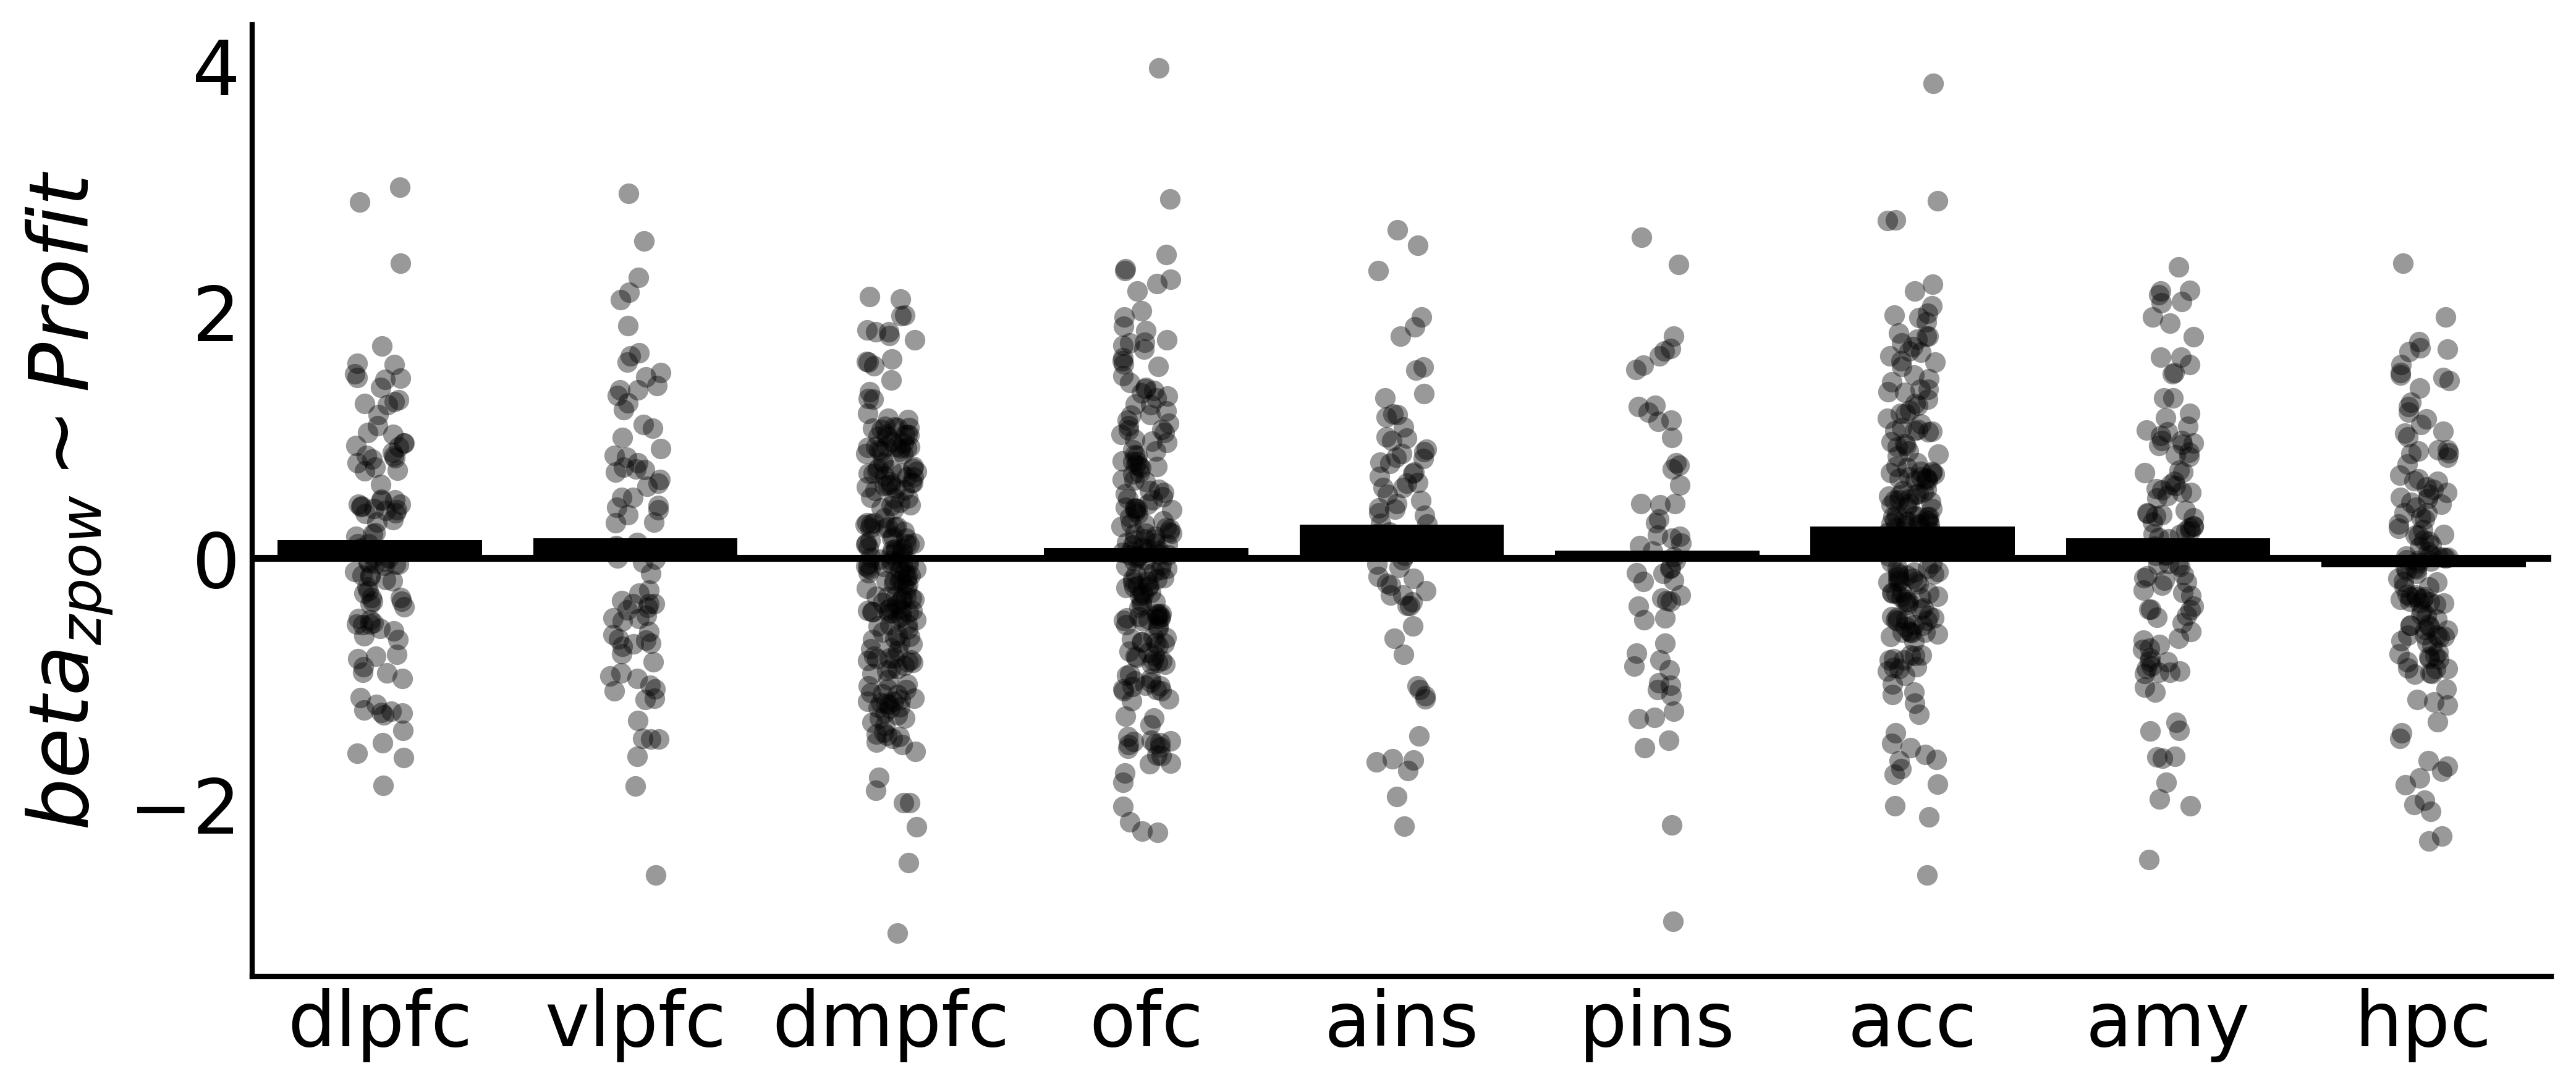

In [46]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

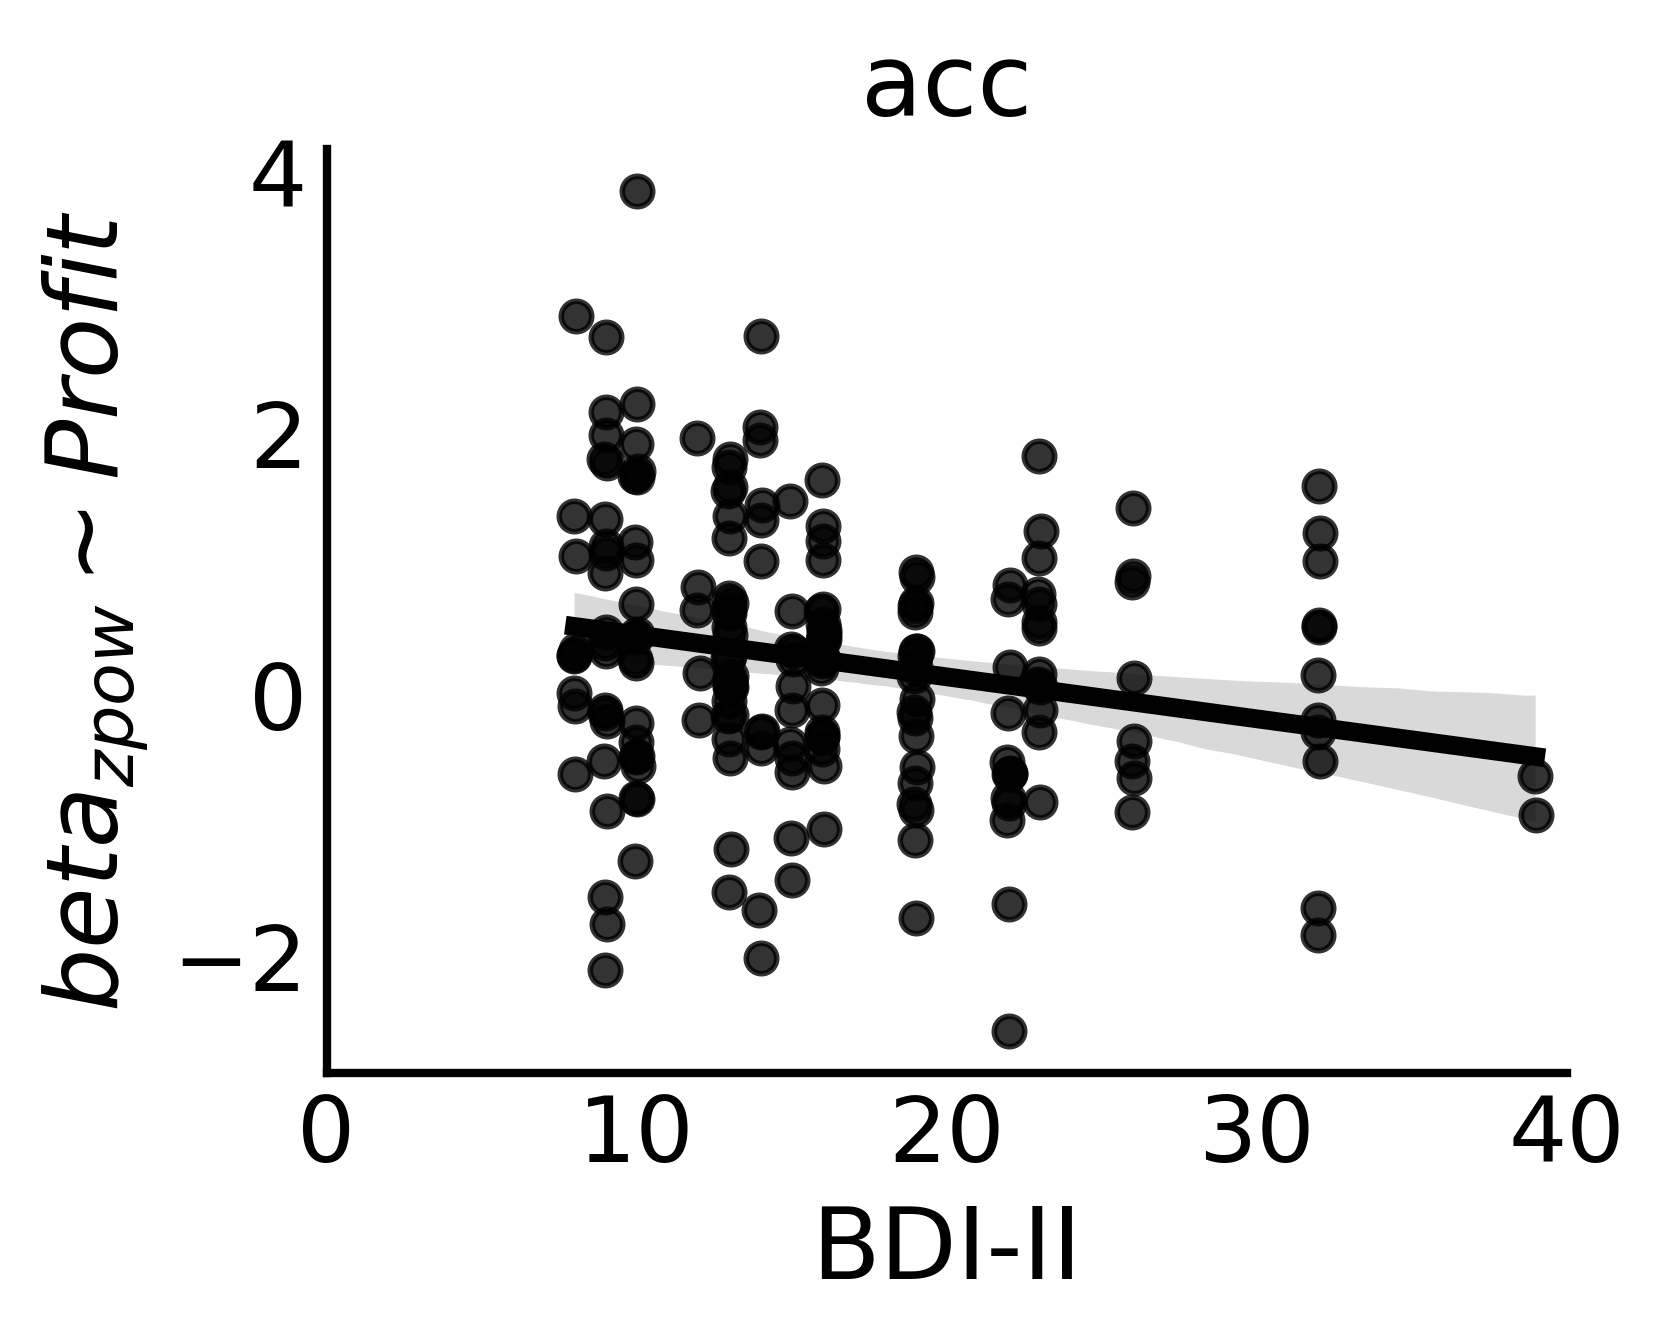

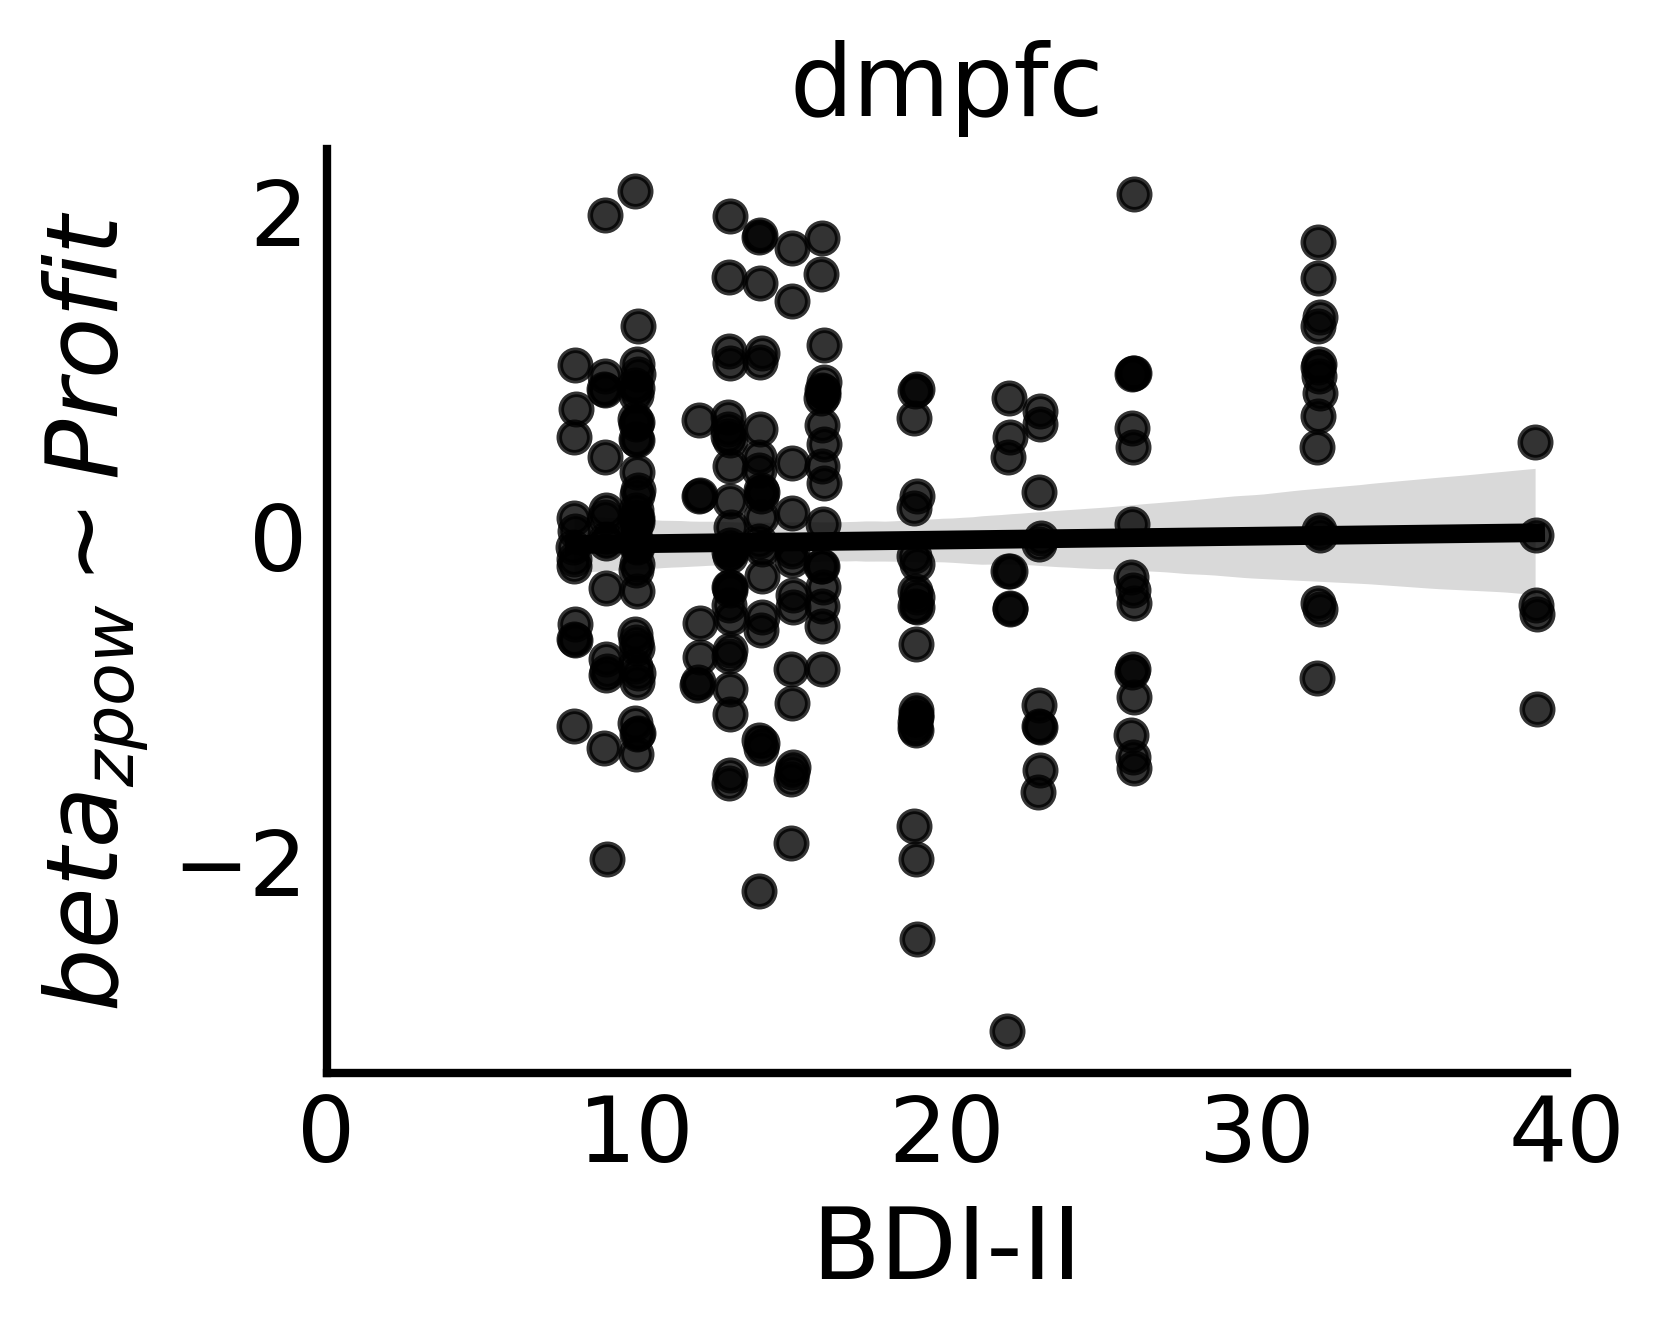

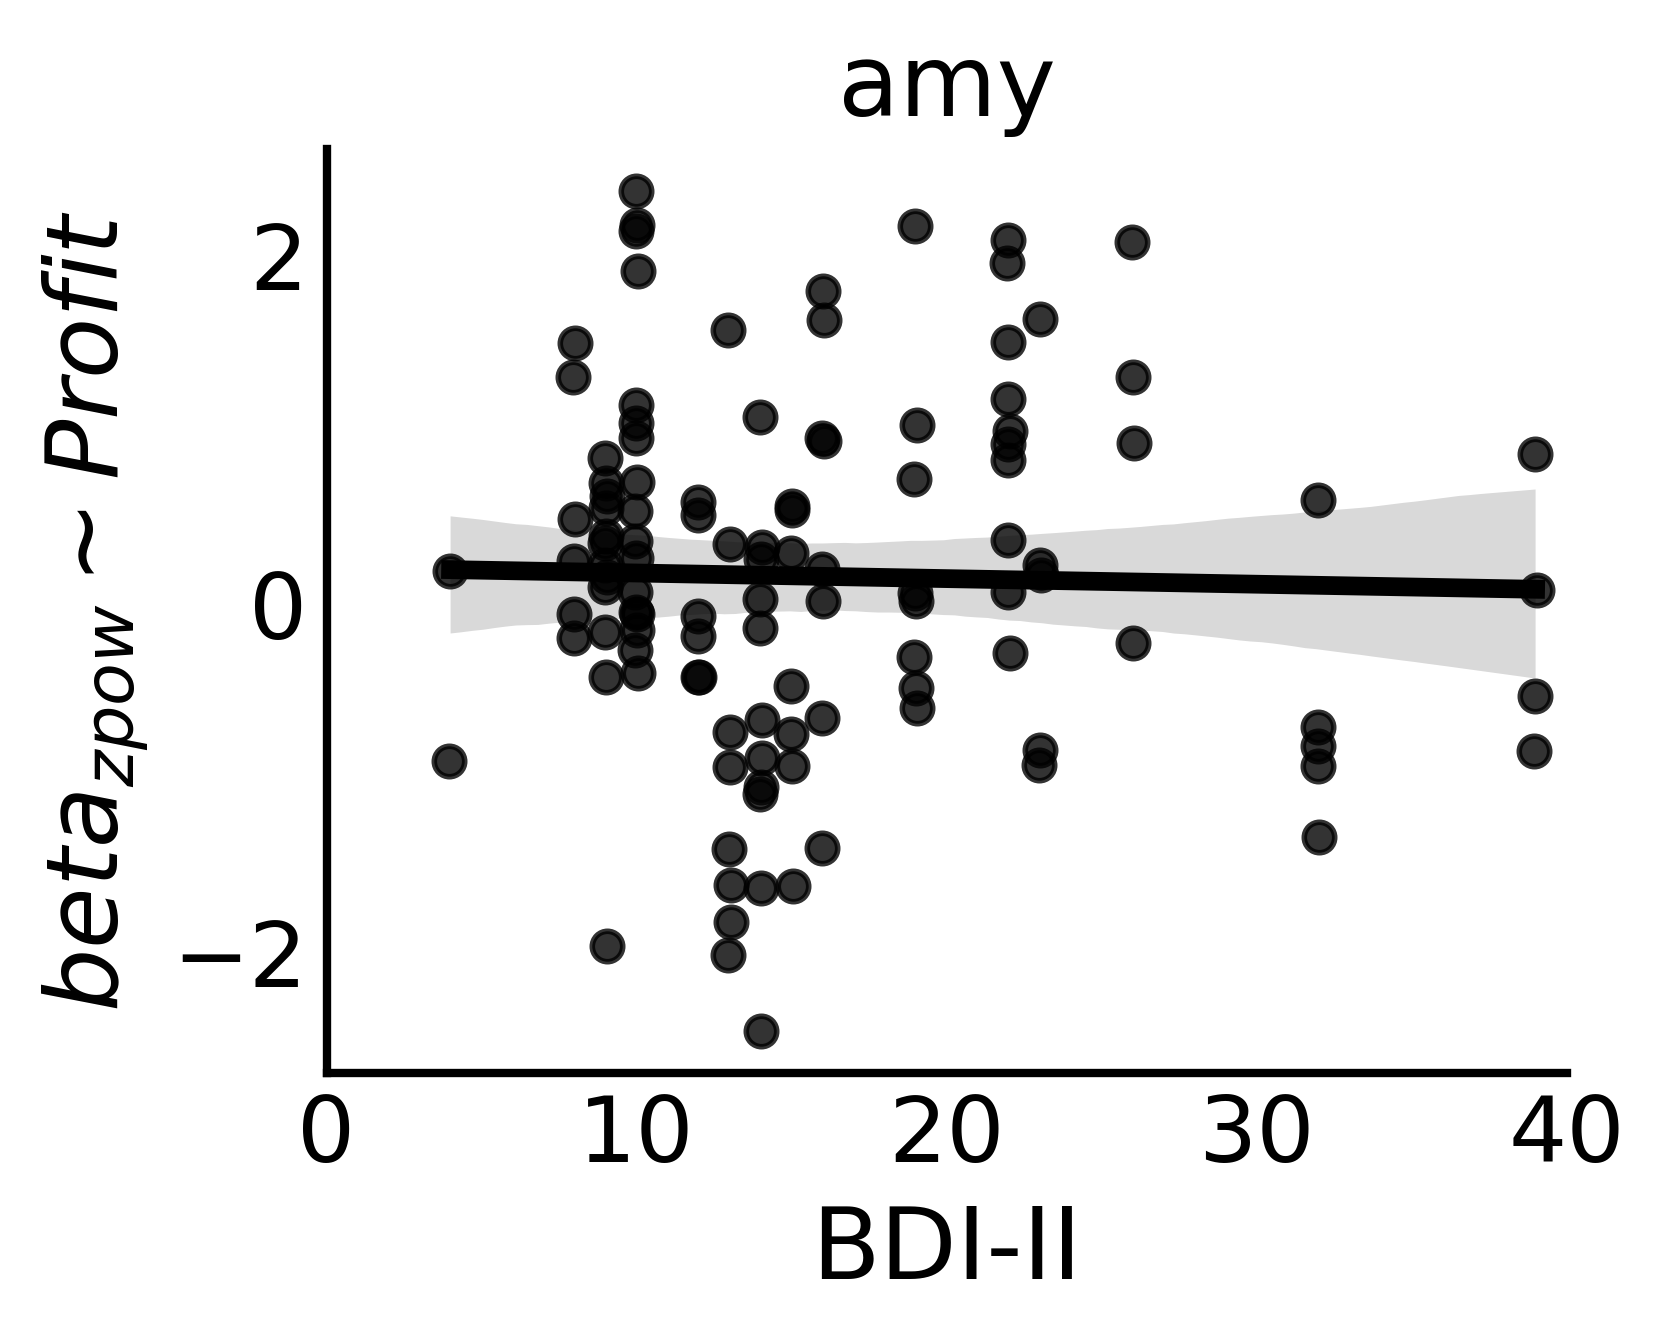

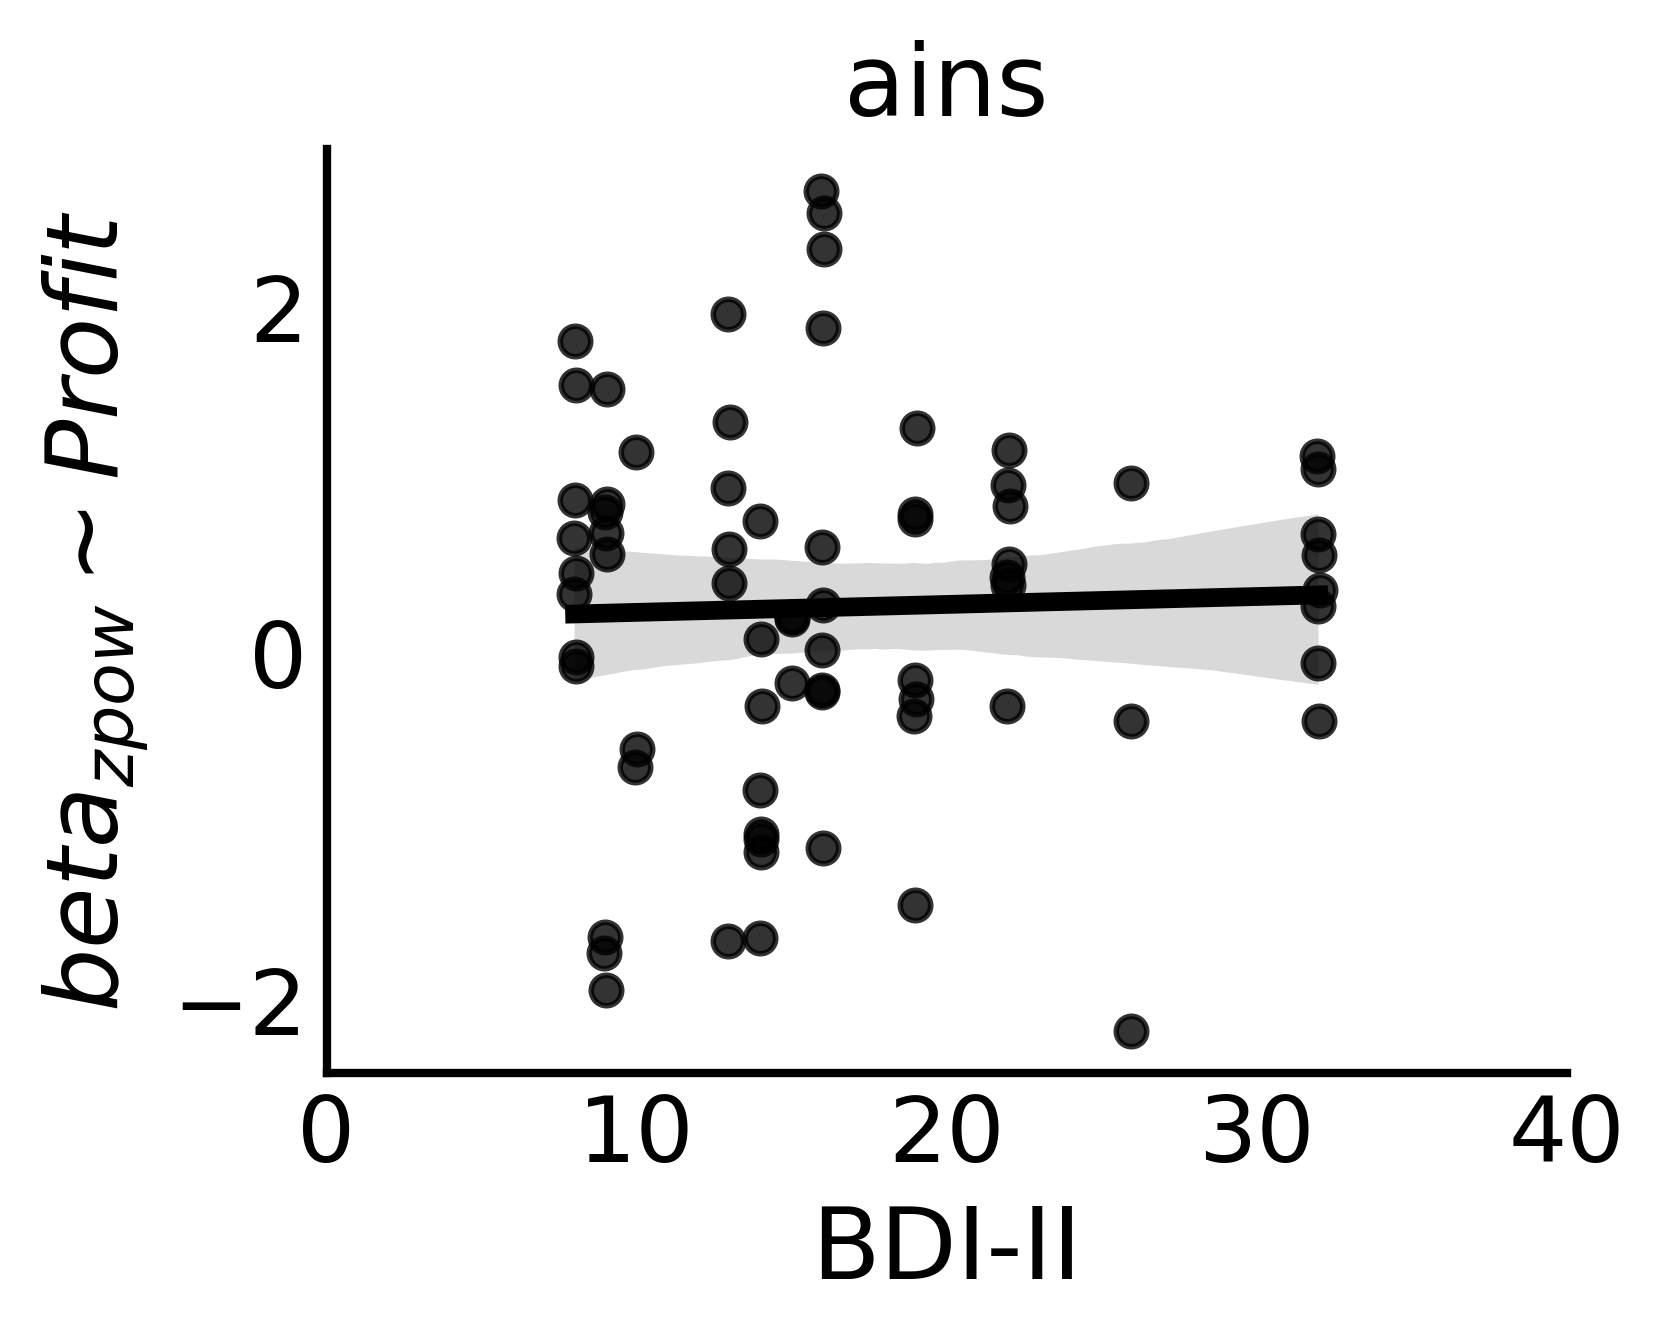

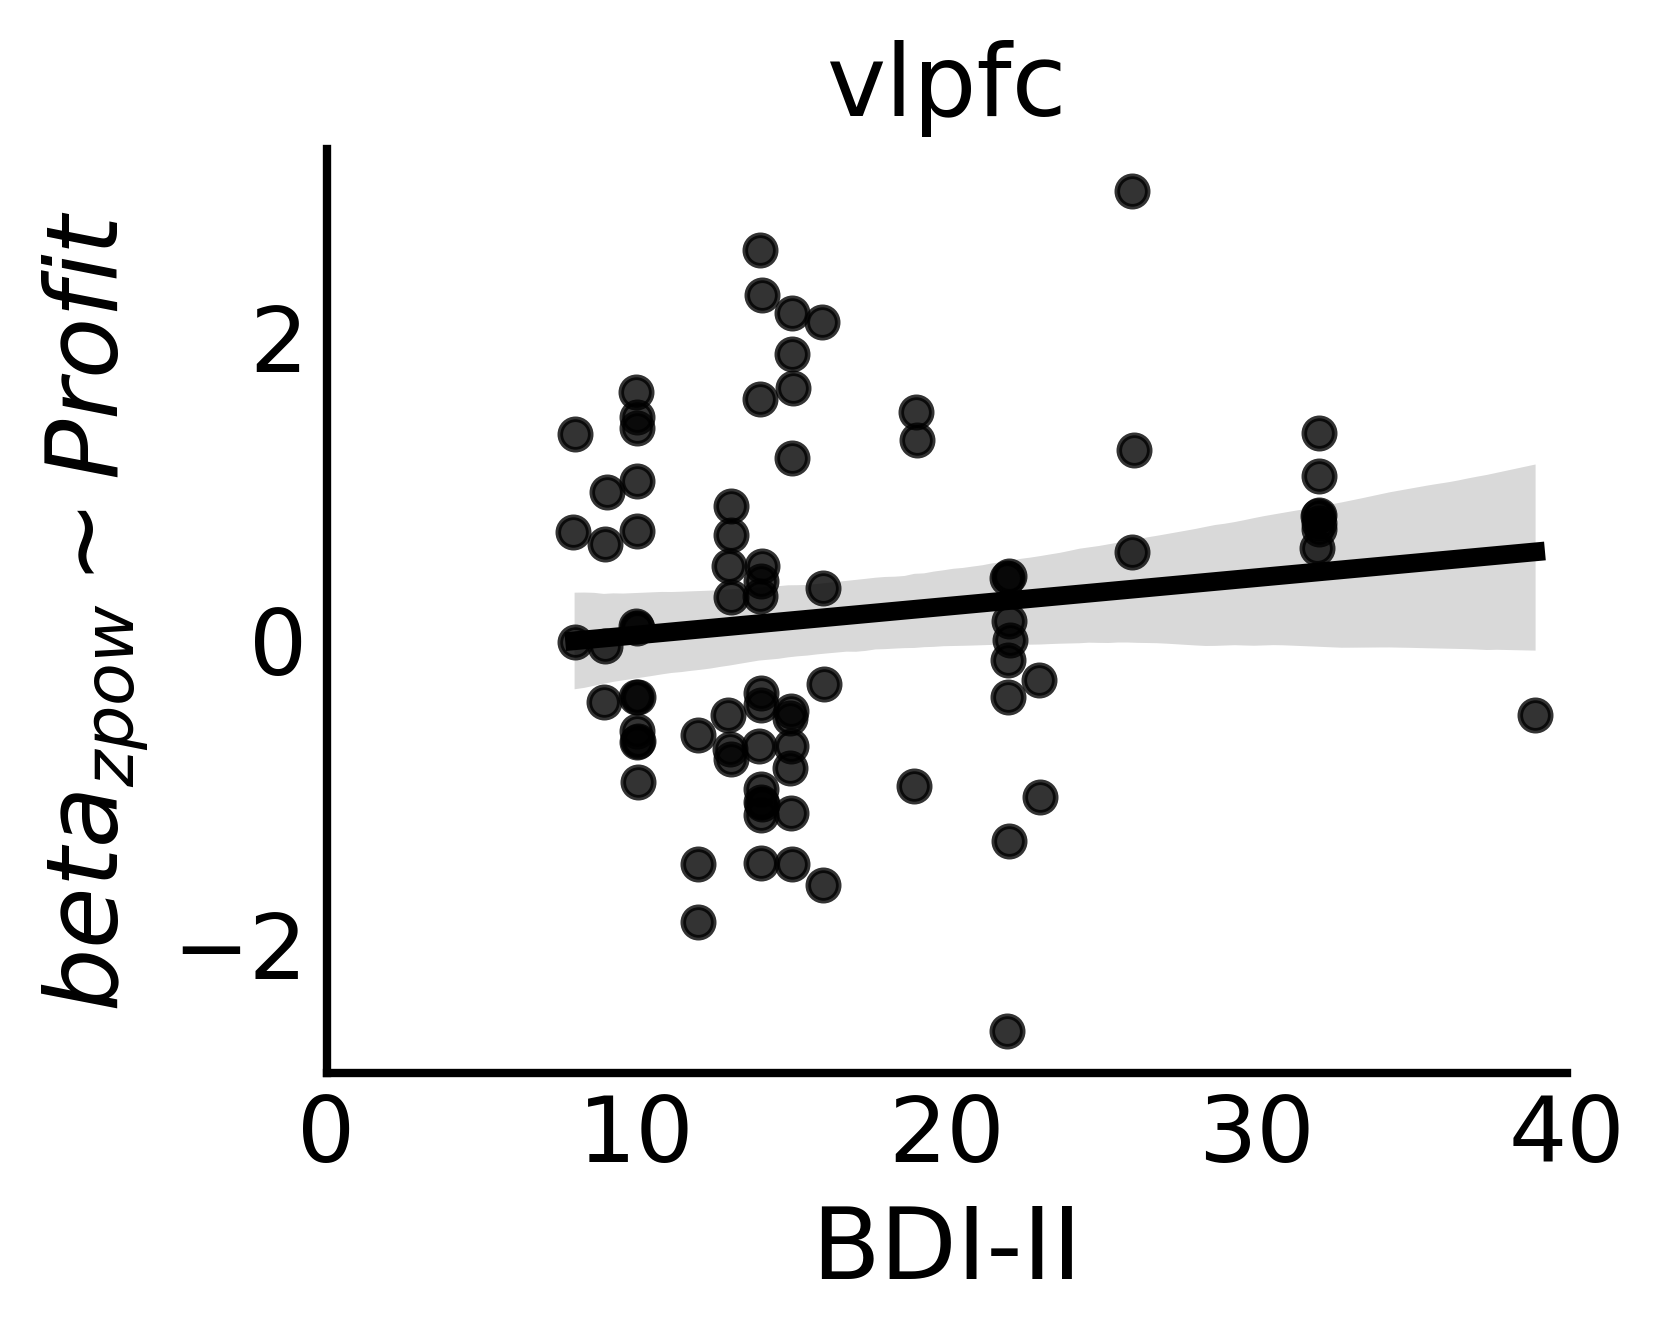

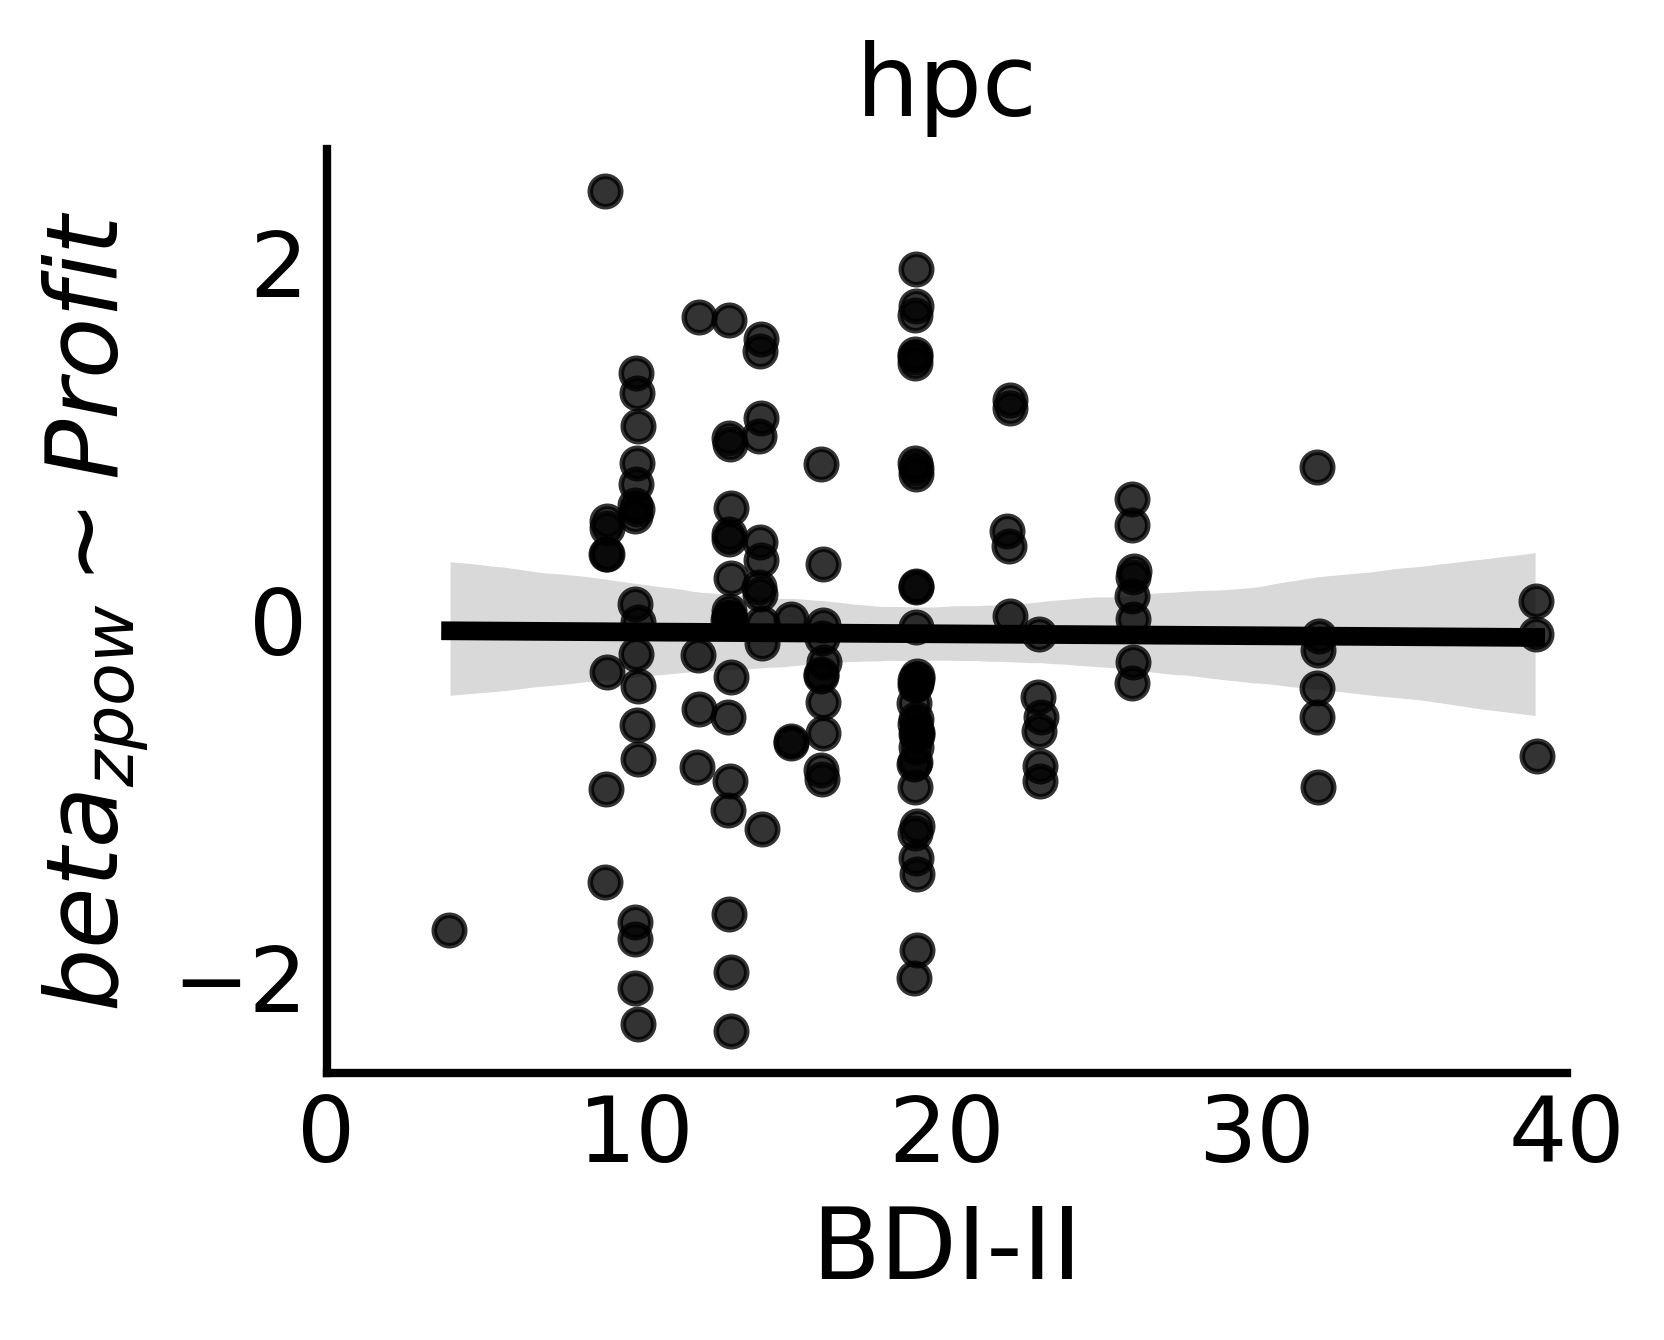

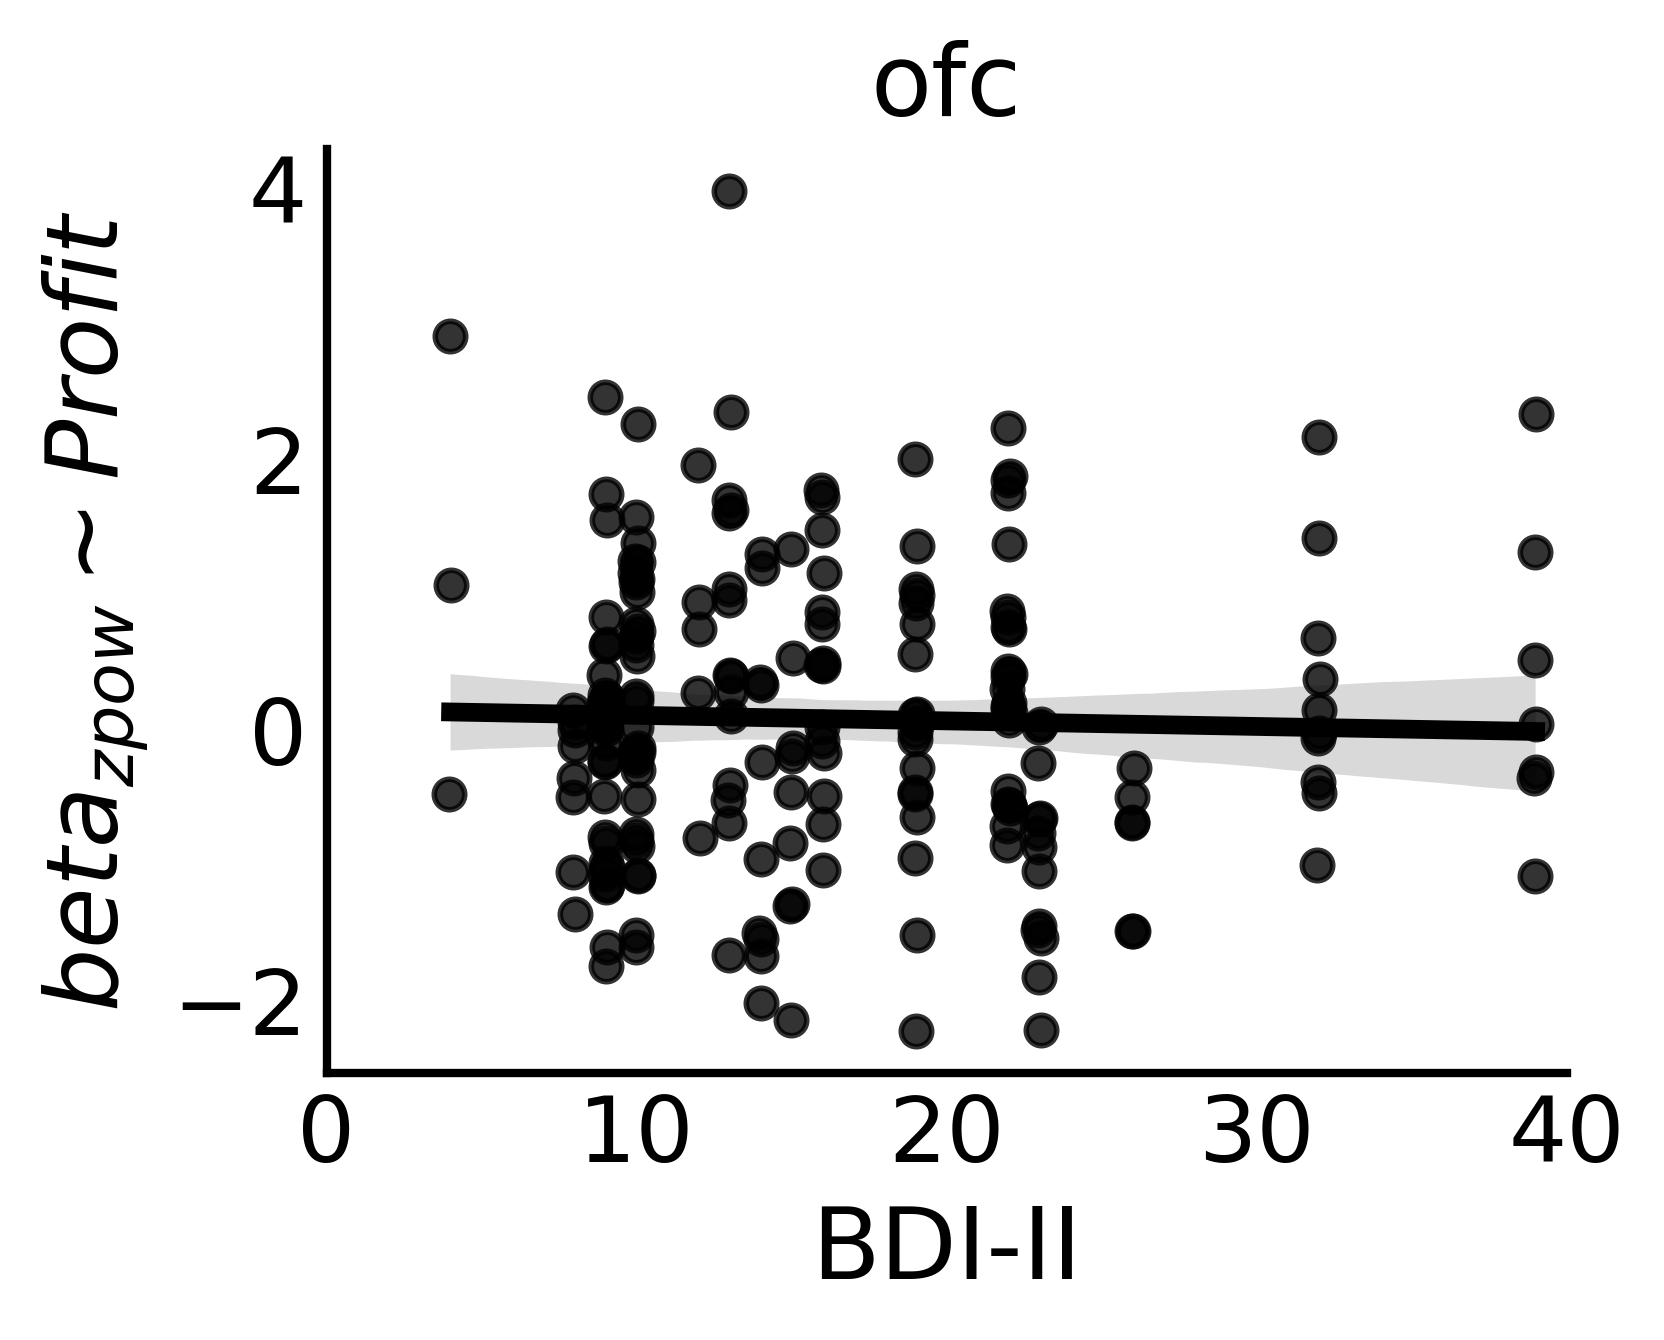

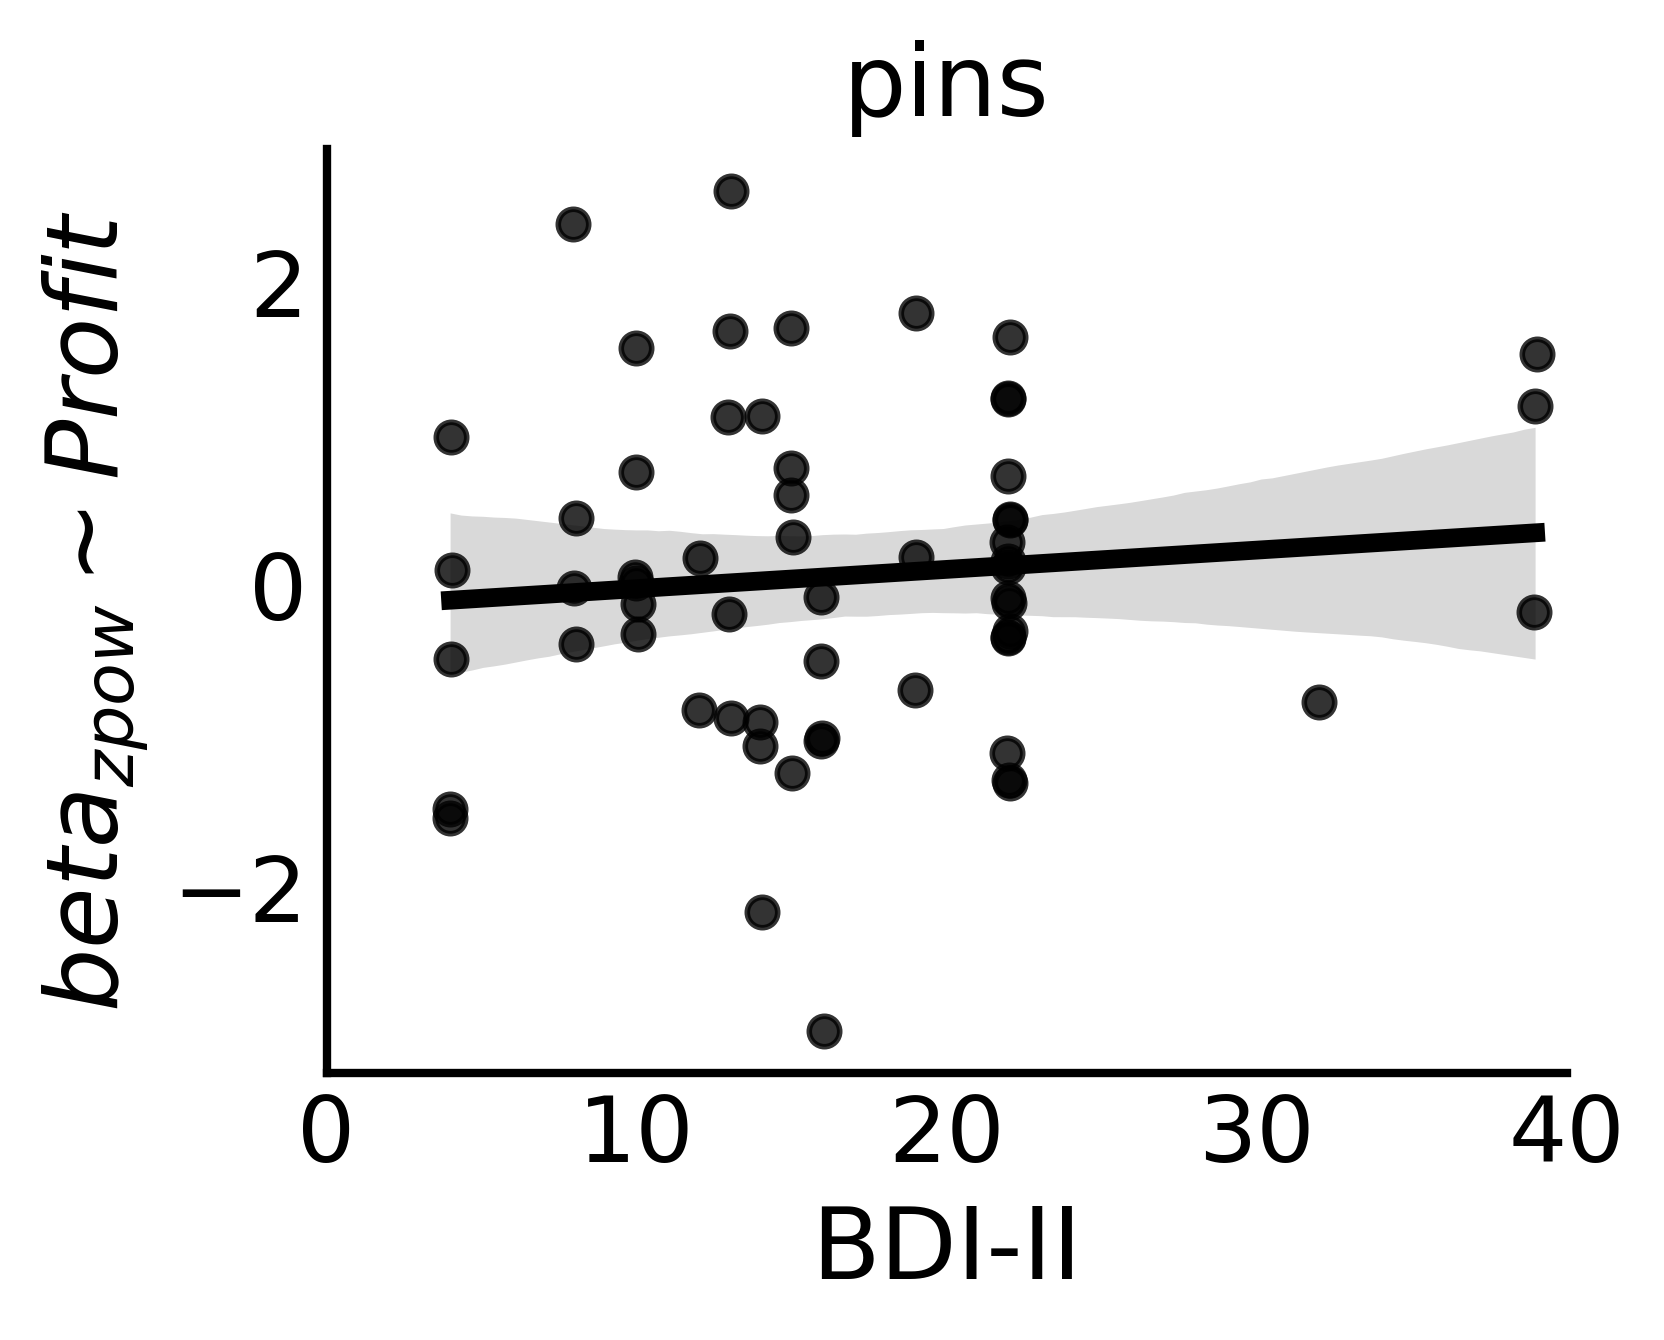

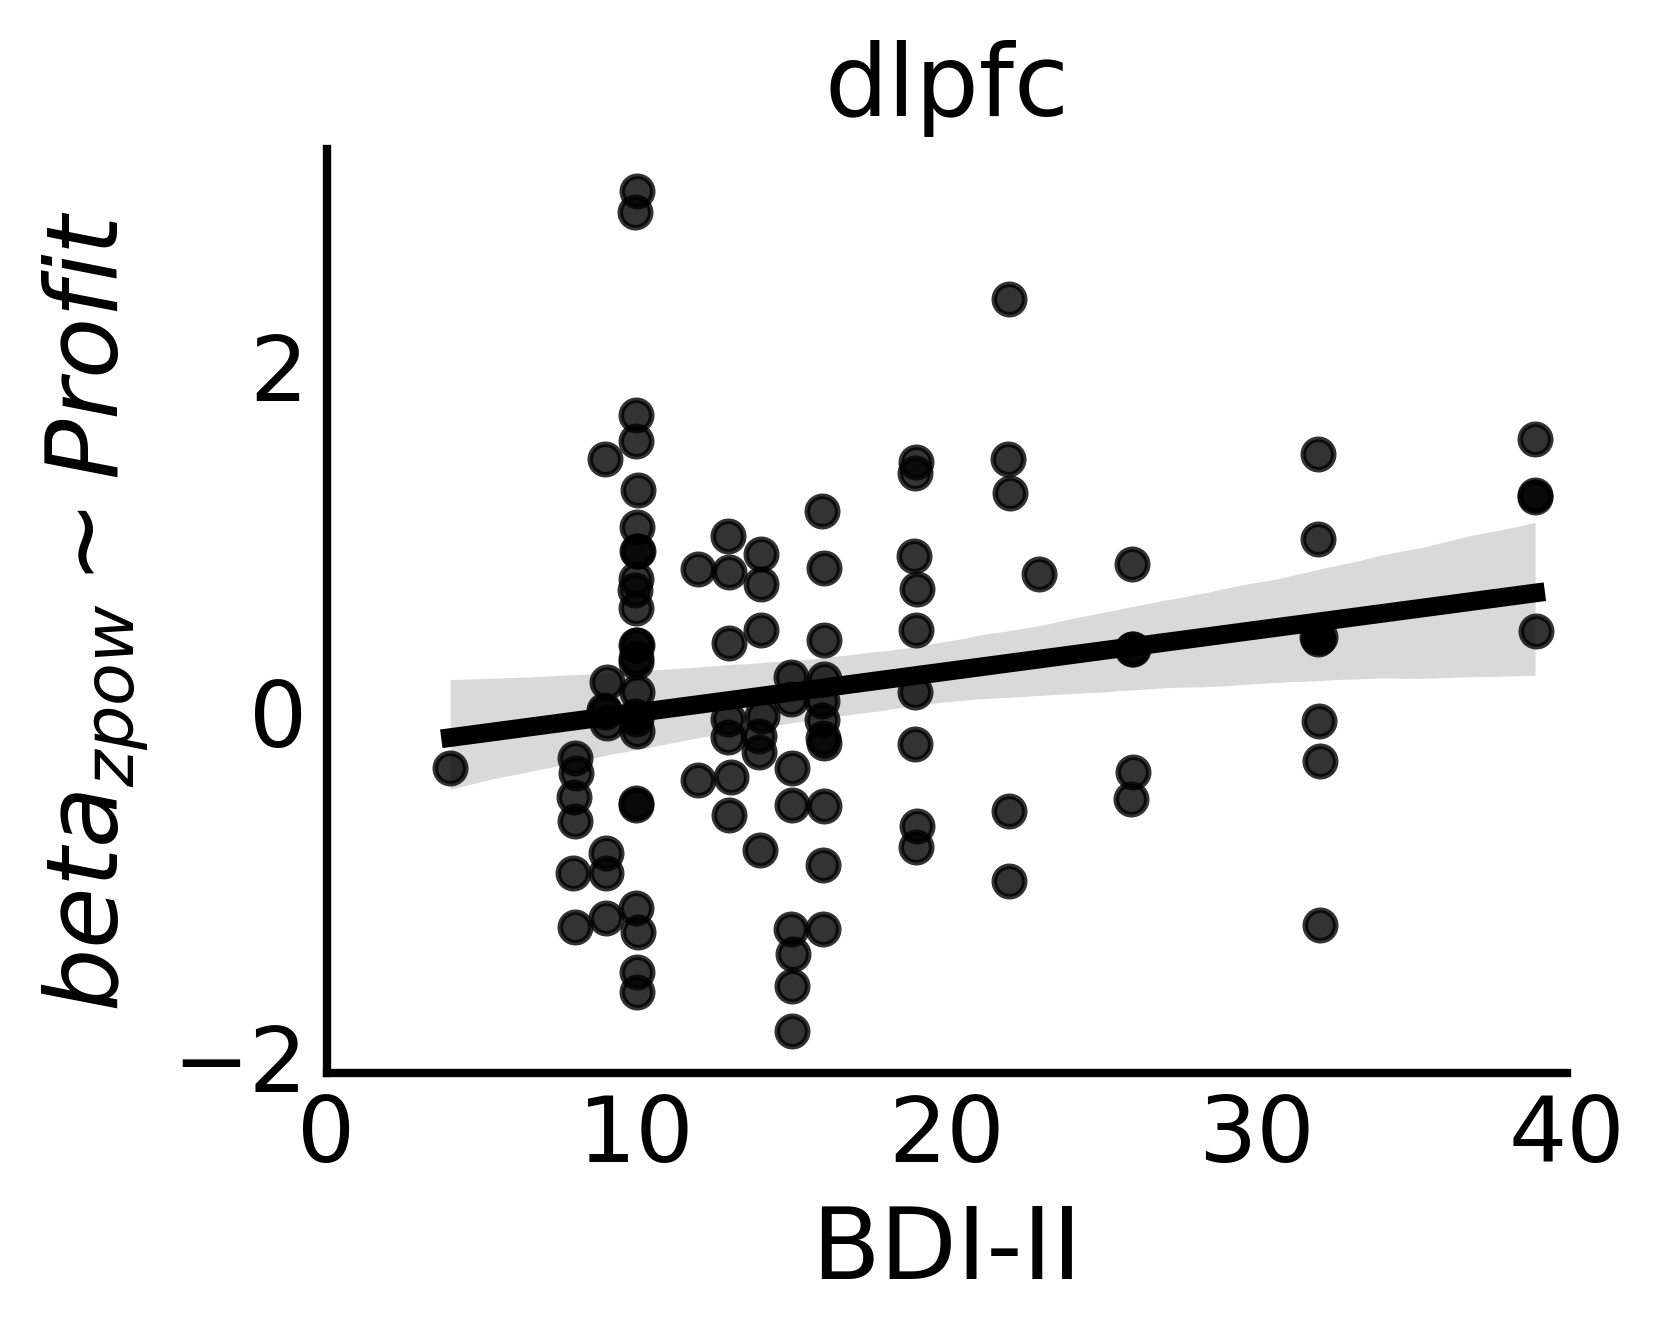

In [47]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_cpeprofmodel_Profit_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [48]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        11:24:46                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9557      0.450     35.493     